# NHL Expected Goals Model

This notebook will look to create a predictive model using xGBoost to predict the liklihood of a goal occuring on a shot. Using data from 10 NHL seasons, I will look to emulate EvolvingWild's xGoal model using Polars and Pandas (rather than R). I want to give them full credit for the idea of building this model. Their model was built out in R and I wanted to better my skills using Polars, Pandas, and Python using their methodology. I also want to credit Evolving Wild with their incredible ability to pique my interest in building a model of this sort as they are wonderful content creators and ask/answer great questions from the NHL analytic community. The methodology of building this model is heavily based on thier methodology (with some additions from myself) and I do not want to take credit for their work without seriously crediting them. This notebook is essentially a way for me to better my skills in different languages and should be considered a translation of their model from R into Python.


Please read their fantastic article [here](https://evolving-hockey.com/blog/a-new-expected-goals-model-for-predicting-goals-in-the-nhl/) to learn more about their methodology.

In [200]:
# Pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# Polars
import polars as pl
pl.Config.set_tbl_rows(n=-1)
pl.Config.set_tbl_cols(n=-1)


# Hockey Specific
import sportsdataverse as sdv
from math import pi
from hockey_rink import NHLRink, RinkImage

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# Modeling
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, classification_report, confusion_matrix, precision_recall_fscore_support, mean_squared_error, accuracy_score, roc_curve, roc_auc_score, auc, make_scorer, precision_score, recall_score, log_loss, f1_score
import xgboost as xgb
from xgboost import XGBClassifier

# HyperTuning
import optuna
from optuna.samplers import TPESampler

# 1) Load NHL Play By Play Data

Here, I will create 3 functions to help clean and tweak play-by-play data that will be sourced from the NHL API and loaded as a Polars DF with the help of SportsDataVerse. Learn more about SportsDataVerse [here](https://sportsdataverse-py.sportsdataverse.org/docs/nhl/).

## *a) Identify Constants (Keys for Events, Game States and Rosters)*

In [201]:
### Event Type Classification ###
xG_Events = ['GOAL', 'SHOT', 'MISSED_SHOT', 'BLOCKED_SHOT', 'FACEOFF', 'TAKEAWAY', 'GIVEAWAY', 'HIT']
fenwick_events = ['SHOT', 'GOAL', 'MISSED_SHOT']
corsi_events = ['SHOT', 'GOAL', 'MISSED_SHOT', 'BLOCKED_SHOT']

# Strength States
EV_STR_Codes = ['5v5', '4v4', '3v3']
PP_STR_Codes = ["5v4", "4v5", "5v3", "3v5", "4v3", "3v4"]
UE_STR_Codes = ["5v4", "4v5", "5v3", "3v5", "4v3", "3v4", "5vE", "Ev5", "4vE", "Ev4", "3vE", "Ev3"]
SH_STR_Codes = ['5v6', '4v5', '3v4', '4v6']

In [202]:
# Load Rosters
roster_file = 'NHL_Rosters_2014_2024.csv'
ROSTER_DF_RAW = pl.read_csv(roster_file)
ROSTER_DF = (
    ROSTER_DF_RAW
    .rename({"player_id": "event_player_1_id"})
    .with_columns([pl.col("event_player_1_id").cast(pl.Int32)])
    .select(['event_player_1_id', 'hand_R', 'hand_L', 'pos_F', 'pos_D', 'pos_G'])
    .unique()
)

# Create Goalie DF
GOALIES = (
    ROSTER_DF_RAW
    .filter(pl.col('pos_G') == 1)
    .with_columns([pl.col("player_id").cast(pl.Int32)])
    .select('player_id',
        (pl.col("first_name").str.to_uppercase() + '.' + pl.col("last_name").str.to_uppercase()).alias('event_goalie_name'),
        'hand_R', 'hand_L'
    )
)
GOALIES.columns = ['event_goalie_id', 'event_goalie_name', 'G_hand_R', 'G_hand_L']

In [203]:
GOALIES.head()

event_goalie_id,event_goalie_name,G_hand_R,G_hand_L
i32,str,i64,i64
8475883,"""FREDERIK.ANDER…",0,1
8476839,"""VIKTOR.FASTH""",0,1
8476434,"""JOHN.GIBSON""",0,1
8473972,"""JONAS.HILLER""",1,0
8468524,"""ILYA.BRYZGALOV…",0,1


## *b) Function: Spatial Normalization and Feature Creation*

- First, I want to clean some of the spatial data. NHL API uses "x_fixed" and "y_fixed" to locate events.
    - x_fixed and y_fixed are cooridates that are "fixed" from perspective of the home team.
    - Since this is an expected goals model, I want the frame of reference to e the location of the event from how far away the event is from the goal of the attacking taem.
- Then I continue to clean and create metrics for the shot distance and angle.
- I also add in some clean classifications for which zone the events occured in
- Finally, we classify penalty shots as their own "game state"

In [204]:
def clean_pbp_data(data):
    """ This function will use inputs from play-by-play data to build usable features in a model.
    Notes:
        1) x_fixed and y_fixed are independent of period and remain constant (Home attacking zone is x_fixed > 0 and Away attacking zone is y_fixed < 0)
        2) Neutral Zone calculation assumes that x coord is > abs(25). >= abs(25) is considered OZ and DZ
    """
    ### EVENT CALCULATIONS ###

    # 1) Create Columns Relative To Event Team
    data = data.with_columns(
      [
        pl.when(data['event_team_type'] == 'away').then(-data['x_fixed']).otherwise(data['x_fixed']).alias('x_abs'),
        pl.when(data['event_team_type'] == 'away').then(-data['y_fixed']).otherwise(data['y_fixed']).alias('y_abs')
      ]
    )
    # 2) Create Zones Using Coordinates
    data = data.with_columns(
      [
        pl.when(data['x_abs'] >= 25).then(pl.lit('OZ'))
        .when((data['x_abs'] > -25) & (data['x_abs'] < 25)).then(pl.lit('NZ'))
        .when(data['x_abs'] <= -25).then(pl.lit('DZ'))
        .otherwise(None)
        .alias('event_zone')
      ]
    )

    data = data.with_columns(
      [
        pl.when((data['event_zone'] == 'OZ') & (data['event_team_type'] == 'home')).then(pl.lit('OZ'))
        .when((data['event_zone'] == 'OZ') & (data['event_team_type'] == 'away')).then(pl.lit('DZ'))
        .when((data['event_zone'] == 'DZ') & (data['event_team_type'] == 'home')).then(pl.lit('DZ'))
        .when((data['event_zone'] == 'DZ') & (data['event_team_type'] == 'away')).then(pl.lit('OZ'))
        .when((data['event_zone'] == 'NZ')).then(pl.lit('NZ'))
        .otherwise(None)
        .alias('home_zone')
      ]
    )
    # 3) Create Event Distance Calculation
    data = data.with_columns(
        pl.when(data['x_abs'] >= 0).then(pl.Series.sqrt((89 - pl.Series.abs(data['x_abs']))**2 + data['y_abs']**2))
          .when(data['x_abs'] <  0).then(pl.Series.sqrt((pl.Series.abs(data['x_abs']) + 89)**2 + data['y_abs']**2))
          .alias('event_distance')
    )
    # 4) Create Event Angle Calculation
    data = (
        data
        .with_columns(
        pl.when(data['x_abs'] >= 0)
          .then(pl.Series.arctan(data['y_abs'] / (89 - pl.Series.abs(data['x_abs'])))
                .apply(lambda x: abs(x * (180 / pi))))
          .when(data['x_abs'] < 0)
          .then(pl.Series.arctan(data['y_abs'] / (pl.Series.abs(data['x_abs']) + 89))
                .apply(lambda x: abs(x * (180 / pi))))
          .alias('event_angle')
        )
        .with_columns(
            pl.when(pl.col('x_abs') > 89).then((180 - pl.col('event_angle'))).otherwise(pl.col('event_angle')).alias('event_angle')
        )
    )
    # 5) Adjust Penalty Shot Game State
    data = data.with_columns(
        [
            pl.when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'home')
            ).then(pl.lit('Ev1'))
            .when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'away')
            ).then(pl.lit('1vE'))
            .otherwise(data['strength_state']).alias('strength_state'),

            pl.when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'home')
            ).then(pl.lit(1))
            .when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'away')
            ).then(pl.lit(0))
            .otherwise(data['home_skaters']).alias('home_skaters'),

            pl.when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'home')
            ).then(pl.lit(0))
            .when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'away')
            ).then(pl.lit(1))
            .otherwise(data['away_skaters']).alias('away_skaters')
        ]
    )

    ### END EVENT CALCULATION ###
    return data
    

## *c) Function: Indexing Operations*

- Now that we have some cleaner data, I want to build some indexes to help organize the play by play data to create time variables used in the model.
- We look to create an index for:
    - Faceoffs
        - *Also used to create which zone in which a play started.*
    - Shifts
    - Penalties
- These indexes will help us to create model features related to time relative to when events occured previously.

In [205]:
def index_input_data(data):
    """ This Function will create indexes and ID's for certain types of plays/events."""

    # 1) Add Zone Start For Corsi Events (i.e., shots)
    fc_idx = (
        data
        .filter((data['event_type'].is_in(['FACEOFF'] + corsi_events)) &
        (((data['period'] < 5) & (data['season_type'] == 'R')) | (data['season_type'] == 'P'))
        )
        .sort('game_id', 'event_idx')
        .with_columns(pl.when(pl.col('event_type') == "FACEOFF").then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_fac'))
        .with_columns(pl.col('is_fac').cumsum().alias('face_index'))
        .select(['game_id', 'event_idx', 'face_index', 'home_zone'])
        .sort('game_id', 'event_idx', 'face_index')
        .with_columns(pl.col('home_zone').first().over(['game_id', 'face_index']).alias('first_home_zone'))
        .with_columns(
            pl.when(pl.first('first_home_zone') == 'OZ').then(1)
            .when(pl.first('first_home_zone') == 'NZ').then(2)
            .when(pl.first('first_home_zone') == 'DZ').then(3)
            .otherwise(pl.lit(None))
            .alias('home_zonestart')
        )
        .select(['game_id', 'event_idx', 'home_zonestart'])
    )
    data = data.join(fc_idx, on=["game_id", "event_idx"], how="left")


    # 2) Create Indexes For Shift and Penalties 

    data = (
        data
        .sort(["season","game_id", "event_idx"])
        .with_columns([
            pl.when(pl.col("event_type") == "FACEOFF").then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_fac'),
            pl.when(pl.col("event_type") == "PENALTY").then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_pen'),
            pl.when(pl.col("event_type") == "CHANGE").then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_shi'),
          ])
        .with_columns([
            pl.col('is_fac').cumsum().alias('face_index'),
            pl.col('is_pen').cumsum().alias('pen_index'),
            pl.col('is_shi').cumsum().alias('shift_index')
        ])
        .sort('season', 'game_id', 'event_idx')
        .with_columns([
            (pl.col('game_seconds').first().over(["season","game_id", "shift_index", 'face_index', "pen_index"])).alias("shift_start_seconds"),
            (pl.col('game_seconds').last().over(["season","game_id", "shift_index", 'face_index', "pen_index"])).alias("shift_end_seconds")
            ])
        .drop(['is_fac', 'is_shi', 'is_pen'])
        )


    gb_cols_1 = ["game_id", "period", "season",
                 "home_on_1", "home_on_2", "home_on_3", "home_on_4", "home_on_5", "home_on_6",
                 "away_on_1", "away_on_2", "away_on_3", "away_on_4", "away_on_5", "away_on_6",
                 "home_goalie", "away_goalie",
                 "face_index", "shift_index", "pen_index"]

    idx_df = (
        data
        .filter(
            (pl.col('event_type').is_in(xG_Events)) &
            (((pl.col('period') < 5) & (pl.col('season_type') == 'R')) | (pl.col('season_type') == 'P'))
        )
        .sort('season', 'game_id', 'event_idx')
        .with_columns([
            (((pl.col("event_idx").first().over(gb_cols_1).cast(pl.Float64)) * (pl.col('game_id').cast(pl.Float64))).round()).alias("shift_ID"),
            (pl.col('game_seconds') - pl.col('shift_start_seconds')).alias('shift_event_secs')
                   ])
        .with_columns([
            (pl.col("shift_event_secs").max().over(gb_cols_1)).alias('shift_length')
        ])
    )
    # Join Indexes To Data (Join All Common Columns)
    idx_cols = idx_df.columns
    data_cols = data.columns
    common_cols = list(set(idx_cols) & set(data_cols))

    data =  data.join(
             idx_df,
             on=common_cols,
             how="left"
         )

    return data

# *d) Function: Separate Data by Game Strength Stae*

Here I am following Evolving Wild's method of splitting data into 4 dataframes to build 4 models for 4 game states:
- Even Strength (5v5, 4v4, 3v3)
- Power-Play/Unequal Advantage (6v5, 6v4, 5v4, 5v3, 4v3)
- Short-Handed (4v5, 3v5, 3v4)
- Empty Net

In [206]:
def split_by_strength(data):
    """This function will split and clean indexed play-by-play data into 4 categories (EV, PP, SH, and EN)"""

    EV_DF = (
        data
        .filter(
            (pl.col('event_type').is_in(xG_Events)) &
            (((pl.col('period') < 5) & (pl.col('season_type') == 'R')) | (pl.col('season_type') == 'P')) &
            (pl.col('secondary_type') != 'Penalty Shot') &
            (~pl.col('x_abs').is_null()) &
            (~pl.col('y_abs').is_null())
        )
        .sort('season', 'game_id', 'period', 'event_idx')
        .with_columns([
            ((pl.col('game_seconds')) - (pl.col('game_seconds').shift(1).over(['season', 'game_id', 'period']))).alias('seconds_since_last'),
            ((pl.col('event_type').shift(1).over(['season', 'game_id', 'period']))).alias('event_type_last'),
            ((pl.col('event_team_abbr').shift(1).over(['season', 'game_id', 'period']))).alias('event_team_last'),
            ((pl.col('strength_state').shift(1).over(['season', 'game_id', 'period']))).alias('event_strength_last'),
            ((pl.col('x_abs').shift(1).over(['season', 'game_id', 'period']))).alias('x_abs_last'),
            ((pl.col('y_abs').shift(1).over(['season', 'game_id', 'period']))).alias('y_abs_last'),
            ((pl.col('home_score').shift(1).over(['season', 'game_id', 'period']))).alias('home_score'),
            ((pl.col('away_score').shift(1).over(['season', 'game_id', 'period']))).alias('away_score'),
            (pl.when((pl.col('event_team_type') == 'home')).then((pl.col('home_goalie')).str.to_uppercase()).otherwise((pl.col('away_goalie').str.to_uppercase())).alias('event_goalie_name'))
        ])
        .sort('season', 'game_id', 'event_idx')
        .filter(
            (pl.col('event_type').is_in(fenwick_events)) &
            (pl.col('strength_state').is_in(EV_STR_Codes)) &
            (~pl.col('x_abs_last').is_null()) &
            (~pl.col('y_abs_last').is_null())
        )
        .with_columns([
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('x_abs_last')).otherwise(pl.col('x_abs_last') * -1).alias('x_abs_last')),
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('y_abs_last')).otherwise(pl.col('y_abs_last') * -1).alias('y_abs_last')),
            (pl.when(pl.col('home_score').is_null()).then(pl.lit(0)).otherwise(pl.col('home_score'))).alias('home_score'),
            (pl.when(pl.col('away_score').is_null()).then(pl.lit(0)).otherwise(pl.col('away_score'))).alias('away_score')
        ])
        .with_columns([
            (pl.when(pl.col('event_team_abbr') == pl.col('event_team_last')).then(pl.lit(1)).otherwise(pl.lit(0))).alias('same_team_last'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_home'),
            (pl.when(pl.col('period_type') == 'OVERTIME').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_overtime'),
            (pl.when(pl.col('season_type') == 'P').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_playoff'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_score') - pl.col('away_score')).otherwise(pl.col('away_score') - pl.col('home_score'))).alias('score_state'),
            (pl.when((pl.col('seconds_since_last') == 0) & (pl.col('event_type_last') == 'FACEOFF')).then(pl.col("shift_length")).otherwise(pl.col('seconds_since_last'))).alias('seconds_since_last'),
            ((((pl.col('x_abs') - pl.col('x_abs_last')) ** 2) + ((pl.col('y_abs') - pl.col('y_abs_last')) ** 2)).sqrt()).alias('distance_from_last')
        ])
        .with_columns(
            pl.when(pl.col('seconds_since_last') == 0).then(pl.lit(0.5)).otherwise(pl.col('seconds_since_last')).alias('seconds_since_last'),
            pl.when(pl.col('x_abs_last') >= 0)
            .then((pl.col('y_abs_last') / (89 - (pl.col('x_abs_last').abs()))).arctan()
                    .apply(lambda x: abs(x * (180 / pi))))
            .when(pl.col('x_abs_last') < 0)
            .then((pl.col('y_abs_last') / ((pl.col('x_abs_last').abs()) + 89)).arctan()
                    .apply(lambda x: abs(x * (180 / pi))))
            .alias('event_angle_last')
        )
        .with_columns(
            pl.when(pl.col('x_abs_last') > 89).then((180 - pl.col('event_angle_last'))).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
        )
        .with_columns([
            (pl.col('distance_from_last') / pl.col('seconds_since_last')).alias('puck_speed_since_last'),
            ((pl.col('event_angle') - pl.col('event_angle_last')).abs()).alias('event_angle_change')
            ])
        .with_columns((pl.col('event_angle_change') / pl.col('seconds_since_last')).alias('event_angle_change_speed'))
        .with_columns([
            pl.when(pl.col('puck_speed_since_last').is_infinite()).then(pl.col('distance_from_last') / pl.lit(0.5)).otherwise(pl.col('puck_speed_since_last')).alias('puck_speed_since_last'),
            pl.when(pl.col('event_angle_last').is_infinite()).then(None).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
            ])
        .select(['season', 'game_id', 'game_date', 'event_idx', 'period', 'game_seconds', 'is_overtime', 'is_playoff',
                'strength_state', 'score_state', 'is_home', 
                'event_player_1_name', 'home_goalie', 'away_goalie', 'event_player_1_id', 'event_goalie_name',
                'home_score', 'away_score', 'home_abbreviation', 'away_abbreviation', 'home_skaters', 'away_skaters',
                'event_type', 'event_team', 'event_team_abbr', 'secondary_type',
                'x_abs', 'y_abs', 'shot_distance', 'shot_angle', 'event_angle_last', 'event_angle', 'event_distance',
                'event_angle_change', 'event_angle_change_speed',
                'event_team_last', 'same_team_last', 'event_strength_last', 'event_type_last',
                'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
                'shift_ID', 'shift_length'])
    )

    ## Build PP DataFrame ##
    PP_DF = (
        data
        .filter(
            (pl.col('event_type').is_in(xG_Events)) &
            (((pl.col('period') < 5) & (pl.col('season_type') == 'R')) | (pl.col('season_type') == 'P')) &
            (pl.col('secondary_type') != 'Penalty Shot') &
            (~pl.col('x_abs').is_null()) &
            (~pl.col('y_abs').is_null())
        )
        .sort('season', 'game_id', 'period', 'event_idx')
        .with_columns([
            ((pl.col('game_seconds')) - (pl.col('game_seconds').shift(1).over(['season', 'game_id', 'period']))).alias('seconds_since_last'),
            ((pl.col('event_type').shift(1).over(['season', 'game_id', 'period']))).alias('event_type_last'),
            ((pl.col('event_team_abbr').shift(1).over(['season', 'game_id', 'period']))).alias('event_team_last'),
            ((pl.col('strength_state').shift(1).over(['season', 'game_id', 'period']))).alias('event_strength_last'),
            ((pl.col('x_abs').shift(1).over(['season', 'game_id', 'period']))).alias('x_abs_last'),
            ((pl.col('y_abs').shift(1).over(['season', 'game_id', 'period']))).alias('y_abs_last'),
            ((pl.col('event_angle').shift(1).over(['season', 'game_id', 'period']))).alias('event_angle_last'),
            ((pl.col('home_score').shift(1).over(['season', 'game_id', 'period']))).alias('home_score'),
            ((pl.col('away_score').shift(1).over(['season', 'game_id', 'period']))).alias('away_score'),
            (pl.concat_str([pl.col('home_skaters'), pl.lit('v'), pl.col('away_skaters')])).alias('true_strength_state'),
            (pl.when(pl.col('strength_state').is_in(PP_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_pen'),
            (pl.when(((pl.col('home_skaters') - pl.col('away_skaters')) >= 2) | ((pl.col('away_skaters') - pl.col('home_skaters')) >= 2)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_two_ma'),
            (pl.when((pl.col('event_team_type') == 'home')).then((pl.col('home_goalie')).str.to_uppercase()).otherwise((pl.col('away_goalie').str.to_uppercase())).alias('event_goalie_name'))
        ])
        .with_columns(((pl.col('is_pen')) * ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'pen_index'])))).alias('pen_seconds_since'))
        .with_columns([
            (pl.when((pl.col('pen_seconds_since') > 0) & (pl.col('pen_seconds_since') >= 300)).then(pl.lit(120)).otherwise(pl.col('pen_seconds_since'))).alias('pen_seconds_since')
            ])
        .sort('season', 'game_id', 'event_idx')
        .filter(
            (pl.col('event_type').is_in(fenwick_events)) &
            (((pl.col('event_team_type') == 'home') & (pl.col('true_strength_state').is_in(["6v5", "6v4", "5v4", "5v3", "4v3"]))) |
            ((pl.col('event_team_type') == 'away') & (pl.col('true_strength_state').is_in(["5v6", "4v6", "4v5", "3v5", "3v4"])))) &
            (~pl.col('x_abs_last').is_null()) &
            (~pl.col('y_abs_last').is_null())
        )
        .with_columns([
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('x_abs_last')).otherwise(pl.col('x_abs_last') * -1).alias('x_abs_last')),
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('y_abs_last')).otherwise(pl.col('y_abs_last') * -1).alias('y_abs_last')),
            (pl.when(pl.col('home_score').is_null()).then(pl.lit(0)).otherwise(pl.col('home_score'))).alias('home_score'),
            (pl.when(pl.col('away_score').is_null()).then(pl.lit(0)).otherwise(pl.col('away_score'))).alias('away_score')
        ])
        .with_columns([
            (pl.when(pl.col('event_team_abbr') == pl.col('event_team_last')).then(pl.lit(1)).otherwise(pl.lit(0))).alias('same_team_last'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_home'),
            (pl.when(pl.col('period_type') == 'OVERTIME').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_overtime'),
            (pl.when(pl.col('season_type') == 'P').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_playoff'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_score') - pl.col('away_score')).otherwise(pl.col('away_score') - pl.col('home_score'))).alias('score_state'),
            (pl.when((pl.col('seconds_since_last') == 0) & (pl.col('event_type_last') == 'FACEOFF')).then(pl.col("shift_length")).otherwise(pl.col('seconds_since_last'))).alias('seconds_since_last'),
            ((((pl.col('x_abs') - pl.col('x_abs_last')) ** 2) + ((pl.col('y_abs') - pl.col('y_abs_last')) ** 2)).sqrt()).alias('distance_from_last'),
            (pl.when(pl.col('event_strength_last').is_in(EV_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_event_EV')
        ])
        .with_columns(
            pl.when(pl.col('seconds_since_last') == 0).then(pl.lit(0.5)).otherwise(pl.col('seconds_since_last')).alias('seconds_since_last'),
            pl.when(pl.col('x_abs_last') >= 0)
            .then((pl.col('y_abs_last') / (89 - (pl.col('x_abs_last').abs()))).arctan()
                    .apply(lambda x: abs(x * (180 / pi))))
            .when(pl.col('x_abs_last') < 0)
            .then((pl.col('y_abs_last') / ((pl.col('x_abs_last').abs()) + 89)).arctan()
                    .apply(lambda x: abs(x * (180 / pi))))
            .alias('event_angle_last')
        )
        .with_columns(
            pl.when(pl.col('x_abs_last') > 89).then((180 - pl.col('event_angle_last'))).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
        )
        .with_columns([
            (pl.col('distance_from_last') / pl.col('seconds_since_last')).alias('puck_speed_since_last'),
            ((pl.col('event_angle') - pl.col('event_angle_last')).abs()).alias('event_angle_change')
            ])
        .with_columns((pl.col('event_angle_change') / pl.col('seconds_since_last')).alias('event_angle_change_speed'))
        .with_columns([
            pl.when(pl.col('puck_speed_since_last').is_infinite()).then(pl.col('distance_from_last') / pl.lit(0.5)).otherwise(pl.col('puck_speed_since_last')).alias('puck_speed_since_last'),
            pl.when(pl.col('event_angle_last').is_infinite()).then(None).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
            ])
        .select([
            'season', 'game_id', 'game_date', 'event_idx', 'period', 'game_seconds', 'is_overtime', 'is_playoff',
            'strength_state', 'true_strength_state', 'score_state', 'is_home', 'is_two_ma',
            'event_player_1_name', 'home_goalie', 'away_goalie', 'event_player_1_id', 'event_goalie_name',
            'home_score', 'away_score', 'home_abbreviation', 'away_abbreviation', 'home_skaters', 'away_skaters',
            'event_type', 'event_team', 'event_team_abbr', 'event_team_type', 'secondary_type',
            'x_abs', 'y_abs', 'shot_distance', 'shot_angle', 'event_angle_last', 'event_angle', 'event_distance',
            'event_angle_change', 'event_angle_change_speed',
            'event_team_last', 'same_team_last', 'event_strength_last', 'prior_event_EV', 'event_type_last',
            'seconds_since_last', 'pen_seconds_since', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
            'shift_ID', 'shift_length'
        ])
    )

    ## Build SH DataFrame ##
    SH_DF = (
        data
        .filter(
            (pl.col('event_type').is_in(xG_Events)) &
            (((pl.col('period') < 5) & (pl.col('season_type') == 'R')) | (pl.col('season_type') == 'P')) &
            (pl.col('secondary_type') != 'Penalty Shot') &
            (~pl.col('x_abs').is_null()) &
            (~pl.col('y_abs').is_null())
        )
        .sort('season', 'game_id', 'period', 'event_idx')
        .with_columns([
            ((pl.col('game_seconds')) - (pl.col('game_seconds').shift(1).over(['season', 'game_id', 'period']))).alias('seconds_since_last'),
            ((pl.col('event_type').shift(1).over(['season', 'game_id', 'period']))).alias('event_type_last'),
            ((pl.col('event_team_abbr').shift(1).over(['season', 'game_id', 'period']))).alias('event_team_last'),
            ((pl.col('strength_state').shift(1).over(['season', 'game_id', 'period']))).alias('event_strength_last'),
            ((pl.col('x_abs').shift(1).over(['season', 'game_id', 'period']))).alias('x_abs_last'),
            ((pl.col('y_abs').shift(1).over(['season', 'game_id', 'period']))).alias('y_abs_last'),
            ((pl.col('event_angle').shift(1).over(['season', 'game_id', 'period']))).alias('event_angle_last'),
            ((pl.col('home_score').shift(1).over(['season', 'game_id', 'period']))).alias('home_score'),
            ((pl.col('away_score').shift(1).over(['season', 'game_id', 'period']))).alias('away_score'),
            (pl.concat_str([pl.col('home_skaters'), pl.lit('v'), pl.col('away_skaters')])).alias('true_strength_state'),
            (pl.when(pl.col('strength_state').is_in(PP_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_pen'),
            (pl.when(((pl.col('home_skaters') - pl.col('away_skaters')) >= 2) | ((pl.col('away_skaters') - pl.col('home_skaters')) >= 2)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_two_ma'),
            (pl.when((pl.col('event_team_type') == 'home')).then((pl.col('home_goalie')).str.to_uppercase()).otherwise((pl.col('away_goalie').str.to_uppercase())).alias('event_goalie_name'))
        ])
        .with_columns([((pl.col('is_pen')) * ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'pen_index'])))).alias('pen_seconds_since')
            ])
        .with_columns((pl.when((pl.col('pen_seconds_since') > 0) & (pl.col('pen_seconds_since') >= 300)).then(pl.lit(120)).otherwise(pl.col('pen_seconds_since'))).alias('pen_seconds_since'))
        .sort('season', 'game_id', 'event_idx')
        .filter(
            (pl.col('event_type').is_in(fenwick_events)) &
            (((pl.col('event_team_type') == 'away') & (pl.col('true_strength_state').is_in(["5v4", "5v3", "4v3"]))) |
            ((pl.col('event_team_type') == 'home') & (pl.col('true_strength_state').is_in(["4v5", "3v5", "3v4"])))) &
            (~pl.col('x_abs_last').is_null()) &
            (~pl.col('y_abs_last').is_null())
        )
        .with_columns([
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('x_abs_last')).otherwise(pl.col('x_abs_last') * -1).alias('x_abs_last')),
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('y_abs_last')).otherwise(pl.col('y_abs_last') * -1).alias('y_abs_last')),
            (pl.when(pl.col('home_score').is_null()).then(pl.lit(0)).otherwise(pl.col('home_score'))).alias('home_score'),
            (pl.when(pl.col('away_score').is_null()).then(pl.lit(0)).otherwise(pl.col('away_score'))).alias('away_score')
        ])
        .with_columns([
            (pl.when(pl.col('event_team_abbr') == pl.col('event_team_last')).then(pl.lit(1)).otherwise(pl.lit(0))).alias('same_team_last'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_home'),
            (pl.when(pl.col('period_type') == 'OVERTIME').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_overtime'),
            (pl.when(pl.col('season_type') == 'P').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_playoff'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_score') - pl.col('away_score')).otherwise(pl.col('away_score') - pl.col('home_score'))).alias('score_state'),
            (pl.when((pl.col('seconds_since_last') == 0) & (pl.col('event_type_last') == 'FACEOFF')).then(pl.col("shift_length")).otherwise(pl.col('seconds_since_last'))).alias('seconds_since_last'),
            ((((pl.col('x_abs') - pl.col('x_abs_last')) ** 2) + ((pl.col('y_abs') - pl.col('y_abs_last')) ** 2)).sqrt()).alias('distance_from_last'),
            (pl.when(pl.col('event_strength_last').is_in(EV_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_event_EV')
        ])
        .with_columns(
            pl.when(pl.col('seconds_since_last') == 0).then(pl.lit(0.5)).otherwise(pl.col('seconds_since_last')).alias('seconds_since_last'),
            pl.when(pl.col('x_abs_last') >= 0)
            .then((pl.col('y_abs_last') / (89 - (pl.col('x_abs_last').abs()))).arctan()
                    .apply(lambda x: abs(x * (180 / pi))))
            .when(pl.col('x_abs_last') < 0)
            .then((pl.col('y_abs_last') / ((pl.col('x_abs_last').abs()) + 89)).arctan()
                    .apply(lambda x: abs(x * (180 / pi))))
            .alias('event_angle_last')
        )
        .with_columns(
            pl.when(pl.col('x_abs_last') > 89).then((180 - pl.col('event_angle_last'))).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
        )
        .with_columns([
            (pl.col('distance_from_last') / pl.col('seconds_since_last')).alias('puck_speed_since_last'),
            ((pl.col('event_angle') - pl.col('event_angle_last')).abs()).alias('event_angle_change')
            ])
        .with_columns((pl.col('event_angle_change') / pl.col('seconds_since_last')).alias('event_angle_change_speed'))
        .with_columns([
            pl.when(pl.col('puck_speed_since_last').is_infinite()).then(pl.col('distance_from_last') / pl.lit(0.5)).otherwise(pl.col('puck_speed_since_last')).alias('puck_speed_since_last'),
            pl.when(pl.col('event_angle_last').is_infinite()).then(None).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
            ])
        .select([
            'season', 'game_id', 'game_date', 'event_idx', 'period', 'game_seconds', 'is_overtime', 'is_playoff',
            'strength_state', 'true_strength_state', 'score_state', 'is_home', 'is_two_ma',
            'event_player_1_name', 'home_goalie', 'away_goalie', 'event_player_1_id', 'event_goalie_name',
            'home_score', 'away_score', 'home_abbreviation', 'away_abbreviation', 'home_skaters', 'away_skaters',
            'event_type', 'event_team', 'event_team_abbr', 'event_team_type', 'secondary_type',
            'x_abs', 'y_abs', 'shot_distance', 'shot_angle', 'event_angle_last', 'event_angle', 'event_distance',
            'event_angle_change', 'event_angle_change_speed',
            'event_team_last', 'same_team_last', 'event_strength_last', 'prior_event_EV', 'event_type_last',
            'seconds_since_last', 'pen_seconds_since', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
            'shift_ID', 'shift_length'
        ])
    )

    ## Build Empty Net DataFrame ##
    EN_DF = (
        data
        .filter(
            (pl.col('event_type').is_in(xG_Events)) &
            (((pl.col('period') < 5) & (pl.col('season_type') == 'R')) | (pl.col('season_type') == 'P')) &
            (pl.col('secondary_type') != 'Penalty Shot') &
            (~pl.col('x_abs').is_null()) &
            (~pl.col('y_abs').is_null())
        )
        .sort('season', 'game_id', 'period', 'event_idx')
        .with_columns([
            ((pl.col('game_seconds')) - (pl.col('game_seconds').shift(1).over(['season', 'game_id', 'period']))).alias('seconds_since_last'),
            ((pl.col('event_type').shift(1).over(['season', 'game_id', 'period']))).alias('event_type_last'),
            ((pl.col('event_team_abbr').shift(1).over(['season', 'game_id', 'period']))).alias('event_team_last'),
            ((pl.col('strength_state').shift(1).over(['season', 'game_id', 'period']))).alias('event_strength_last'),
            ((pl.col('x_abs').shift(1).over(['season', 'game_id', 'period']))).alias('x_abs_last'),
            ((pl.col('y_abs').shift(1).over(['season', 'game_id', 'period']))).alias('y_abs_last'),
            ((pl.col('home_score').shift(1).over(['season', 'game_id', 'period']))).alias('home_score'),
            ((pl.col('away_score').shift(1).over(['season', 'game_id', 'period']))).alias('away_score'),
            ((pl.col('event_angle').shift(1).over(['season', 'game_id', 'period']))).alias('event_angle_last'),
            (pl.when(pl.col('home_goalie').is_null()).then(pl.lit('E')).otherwise(pl.col('home_skaters'))).alias('home_skaters_true'),
            (pl.when(pl.col('away_goalie').is_null()).then(pl.lit('E')).otherwise(pl.col('away_skaters'))).alias('away_skaters_true'),
            (pl.when(pl.col('strength_state').is_in(PP_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_pen'),
            (pl.when(((pl.col('home_skaters') - pl.col('away_skaters')) >= 2) | ((pl.col('away_skaters') - pl.col('home_skaters')) >= 2)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_two_ma')
        ])
        .with_columns((pl.concat_str([pl.col('home_skaters_true'), pl.lit('v'), pl.col('away_skaters_true')])).alias('true_strength_state'))
        .sort('season', 'game_id', 'event_idx')
        .filter(
            (pl.col('event_type').is_in(fenwick_events)) &
            (((pl.col('event_team_type') == 'away') & (pl.col('true_strength_state').is_in(["Ev5", "Ev4", "Ev3"]))) |
            ((pl.col('event_team_type') == 'home') & (pl.col('true_strength_state').is_in(["5vE", "4vE", "3vE"])))) &
            (~pl.col('x_abs_last').is_null()) &
            (~pl.col('y_abs_last').is_null())
        )
        .with_columns([
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('x_abs_last')).otherwise(pl.col('x_abs_last') * -1).alias('x_abs_last')),
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('y_abs_last')).otherwise(pl.col('y_abs_last') * -1).alias('y_abs_last')),
            (pl.when(pl.col('home_score').is_null()).then(pl.lit(0)).otherwise(pl.col('home_score'))).alias('home_score'),
            (pl.when(pl.col('away_score').is_null()).then(pl.lit(0)).otherwise(pl.col('away_score'))).alias('away_score')
        ])
        .with_columns([
            (pl.when(pl.col('event_team_abbr') == pl.col('event_team_last')).then(pl.lit(1)).otherwise(pl.lit(0))).alias('same_team_last'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_home'),
            (pl.when(pl.col('period_type') == 'OVERTIME').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_overtime'),
            (pl.when(pl.col('season_type') == 'P').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_playoff'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_score') - pl.col('away_score')).otherwise(pl.col('away_score') - pl.col('home_score'))).alias('score_state'),
            (pl.when((pl.col('seconds_since_last') == 0) & (pl.col('event_type_last') == 'FACEOFF')).then(pl.col("shift_length")).otherwise(pl.col('seconds_since_last'))).alias('seconds_since_last'),
            ((((pl.col('x_abs') - pl.col('x_abs_last')) ** 2) + ((pl.col('y_abs') - pl.col('y_abs_last')) ** 2)).sqrt()).alias('distance_from_last'),
            (pl.when(pl.col('event_strength_last').is_in(EV_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_event_EV'),
            (pl.when(pl.col('strength_state').is_in(EV_STR_Codes + ['6v6'])).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_EV')
        ])
        .with_columns(
            pl.when(pl.col('seconds_since_last') == 0).then(pl.lit(0.5)).otherwise(pl.col('seconds_since_last')).alias('seconds_since_last'),
            pl.when(pl.col('x_abs_last') >= 0)
            .then((pl.col('y_abs_last') / (89 - (pl.col('x_abs_last').abs()))).arctan()
                    .apply(lambda x: abs(x * (180 / pi))))
            .when(pl.col('x_abs_last') < 0)
            .then((pl.col('y_abs_last') / ((pl.col('x_abs_last').abs()) + 89)).arctan()
                    .apply(lambda x: abs(x * (180 / pi))))
            .alias('event_angle_last')
        )
        .with_columns(
            pl.when(pl.col('x_abs_last') > 89).then((180 - pl.col('event_angle_last'))).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
        )
        .with_columns([
            (pl.col('distance_from_last') / pl.col('seconds_since_last')).alias('puck_speed_since_last'),
            ((pl.col('event_angle') - pl.col('event_angle_last')).abs()).alias('event_angle_change')
            ])
        .with_columns((pl.col('event_angle_change') / pl.col('seconds_since_last')).alias('event_angle_change_speed'))
        .with_columns([
            pl.when(pl.col('puck_speed_since_last').is_infinite()).then(pl.col('distance_from_last') / pl.lit(0.5)).otherwise(pl.col('puck_speed_since_last')).alias('puck_speed_since_last'),
            pl.when(pl.col('event_angle_last').is_infinite()).then(None).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
            ])
        .select([
            'season', 'game_id', 'game_date', 'event_idx', 'period', 'game_seconds', 'is_overtime', 'is_playoff',
            'strength_state', 'true_strength_state', 'score_state', 'is_home', 'is_two_ma', 'is_pen', 'is_EV',
            'event_player_1_name', 'home_goalie', 'away_goalie', 'event_player_1_id',
            'home_score', 'away_score', 'home_abbreviation', 'away_abbreviation', 'home_skaters', 'away_skaters',
            'event_type', 'event_team', 'event_team_abbr', 'event_team_type', 'secondary_type', 
            'x_abs', 'y_abs', 'shot_distance', 'shot_angle', 'event_angle', 'event_distance',
            'event_angle_change', 'event_angle_change_speed',
            'event_team_last', 'same_team_last', 'event_strength_last', 'prior_event_EV', 'event_type_last',
            'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
            'shift_ID', 'shift_length'
        ])
    )
    return EV_DF, PP_DF, SH_DF, EN_DF

## *e) Function: One Hot Encoding and Other Feature Engineering*

Here, I wil look to build some binary columns related to each event to better help the model recognize and categorize each event.

In [218]:
def model_prep(data, prep_type):
    """ This function will prep each dataframe to be inputted into a classification model to predict expected goals """

    if(prep_type == 'EV'):
        model_prep = (
            data
            .join(ROSTER_DF, on=["event_player_1_id"], how = 'left')
            .join(GOALIES, on=["event_goalie_name"], how = 'left')
            .with_columns([
                # Target Variable
                (pl.when(pl.col('event_type') == "GOAL").then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_goal'),
                # Game State
                (pl.when(pl.col('strength_state') == "5v5").then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_5v5'),
                (pl.when(pl.col('strength_state') == "4v4").then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_4v4'),
                (pl.when(pl.col('strength_state') == "3v3").then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_3v3'),
                # Score State
                (pl.when(pl.col('score_state') <= -4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_4'),
                (pl.when(pl.col('score_state') == -3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_3'),
                (pl.when(pl.col('score_state') == -2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_2'),
                (pl.when(pl.col('score_state') == -1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_1'),
                (pl.when(pl.col('score_state') == 0).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_even'),
                (pl.when(pl.col('score_state') == 1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_1'),
                (pl.when(pl.col('score_state') == 2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_2'),
                (pl.when(pl.col('score_state') == 3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_3'),
                (pl.when(pl.col('score_state') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_4'),
                # Prior Shot Outcome
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_same'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_same'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_same'),
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_opp'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_opp'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_opp'),
                # Prior Event - Non Shot
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_opp'),
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_same'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_opp'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_same'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_opp'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_same'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_win'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_lose'),
                # Handiness
                (pl.when(
                    ((pl.col('hand_R') == 1) & (pl.col('y_abs') > 0) & ((pl.col('shot_angle') > 10))) |
                    ((pl.col('hand_L') == 1) & (pl.col('y_abs') < 0) & ((pl.col('shot_angle') > 10)))
                    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias('off_wing')),
                # Create Rebound Flag
                (pl.when(
                (pl.col('event_type_last').is_in(["SHOT", "MISSED_SHOT"])) &
                (pl.col('same_team_last') == 1) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rebound'),
                # Set Play (Faceoff Win + Shot In 5 Seconds)
                (pl.when(
                (pl.col('event_type_last').is_in(["FACEOFF"])) &
                (pl.col('same_team_last') == 1) &
                (pl.col('x_abs_last') > 25) &
                (pl.col('seconds_since_last') <= 4)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_set_play'),
                # Is Rush Play (Transition)
                (pl.when(
                (pl.col('x_abs_last') < 25) &
                (pl.col('seconds_since_last') <= 4)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rush_play')
            ])
            .with_columns([
                pl.when(pl.col('G_hand_R').is_null()).then(pl.lit(0)).otherwise(pl.col('G_hand_R')).alias('G_R_Hand'),
                pl.when(pl.col('G_hand_L').is_null()).then(pl.lit(0)).otherwise(pl.col('G_hand_L')).alias('G_L_Hand')
            ])
        )

        # Get Creates Column Names + Slim
        new_cols = model_prep.columns[-32:]
        model_prep = (
            model_prep
            .select([ 'season', 'game_id', 'event_idx', 'secondary_type',
                'is_goal',
                'period', 'game_seconds','is_home', 'is_overtime', 'is_playoff',
                'x_abs', 'y_abs', 'event_distance', 'event_angle',
                'event_angle_change', 'event_angle_change_speed',
                'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
                'pos_F', 'pos_D', 'pos_G', 'hand_R', 'hand_L',
                'shift_length'] + new_cols
            )
        )

    elif(prep_type == 'PP'):
        model_prep = (
            data
            .join(ROSTER_DF, on=["event_player_1_id"], how = 'left')
            .join(GOALIES, on=["event_goalie_name"], how = 'left')
            .with_columns([
                # Target Variable
                (pl.when(pl.col('event_type') == "GOAL").then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_goal'),
                # Game State
                (pl.when(((pl.col('true_strength_state') == "5v4") & (pl.col('event_team_type') == 'home')) | 
                         ((pl.col('true_strength_state') == "4v5") & (pl.col('event_team_type') == 'away'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_5v4'),
                (pl.when(((pl.col('true_strength_state') == "5v3") & (pl.col('event_team_type') == 'home')) | 
                         ((pl.col('true_strength_state') == "3v5") & (pl.col('event_team_type') == 'away'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_5v3'),
                (pl.when(((pl.col('true_strength_state') == "4v3") & (pl.col('event_team_type') == 'home')) | 
                         ((pl.col('true_strength_state') == "3v4") & (pl.col('event_team_type') == 'away'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_4v3'),
                (pl.when(((pl.col('true_strength_state') == "6v5") & (pl.col('event_team_type') == 'home')) | 
                         ((pl.col('true_strength_state') == "5v6") & (pl.col('event_team_type') == 'away'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_6v5'),
                (pl.when(((pl.col('true_strength_state') == "6v4") & (pl.col('event_team_type') == 'home')) | 
                         ((pl.col('true_strength_state') == "4v6") & (pl.col('event_team_type') == 'away'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_6v4'),
                # Score State
                (pl.when(pl.col('score_state') <= -4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_4'),
                (pl.when(pl.col('score_state') == -3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_3'),
                (pl.when(pl.col('score_state') == -2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_2'),
                (pl.when(pl.col('score_state') == -1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_1'),
                (pl.when(pl.col('score_state') == 0).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_even'),
                (pl.when(pl.col('score_state') == 1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_1'),
                (pl.when(pl.col('score_state') == 2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_2'),
                (pl.when(pl.col('score_state') == 3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_3'),
                (pl.when(pl.col('score_state') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_4'),
                # Prior Shot Outcome
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_same'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_same'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_same'),
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_opp'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_opp'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_opp'),
                # Prior Event - Non Shot
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_opp'),
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_same'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_opp'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_same'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_opp'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_same'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_win'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_lose'),
                # Handiness
                (pl.when(
                    ((pl.col('hand_R') == 1) & (pl.col('y_abs') > 0) & ((pl.col('shot_angle') > 10))) |
                    ((pl.col('hand_L') == 1) & (pl.col('y_abs') < 0) & ((pl.col('shot_angle') > 10)))
                    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias('off_wing')),
                # Create Rebound Flag
                (pl.when(
                (pl.col('event_type_last').is_in(["SHOT", "MISSED_SHOT"])) &
                (pl.col('same_team_last') == 1) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rebound'),
                # Set Play (Faceoff Win + Shot In 5 Seconds)
                (pl.when(
                (pl.col('event_type_last').is_in(["FACEOFF"])) &
                (pl.col('same_team_last') == 1) &
                (pl.col('x_abs_last') > 25) &
                (pl.col('seconds_since_last') <= 4)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_set_play'),
                # Is Rush Play (Transition)
                (pl.when(
                (pl.col('x_abs_last') < 0) &
                (pl.col('seconds_since_last') <= 5)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rush_play')
            ])
            .with_columns([
                pl.when(pl.col('G_hand_R').is_null()).then(pl.lit(0)).otherwise(pl.col('G_hand_R')).alias('G_R_Hand'),
                pl.when(pl.col('G_hand_L').is_null()).then(pl.lit(0)).otherwise(pl.col('G_hand_L')).alias('G_L_Hand')
            ])
        )

        # Get Creates Column Names + Slim
        new_cols = model_prep.columns[-34:]
        model_prep = (
            model_prep
            .select([ 'season', 'game_id', 'event_idx', 'secondary_type',
                'is_goal',
                'period', 'game_seconds','is_home', 'is_overtime', 'is_playoff',
                'x_abs', 'y_abs', 'event_angle', 'event_distance',
                'event_angle_change', 'event_angle_change_speed',
                'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
                'pen_seconds_since', 'prior_event_EV', 'is_two_ma',
                'pos_F', 'pos_D', 'pos_G', 'hand_R', 'hand_L',
                'shift_length'] + new_cols
            )
        )

    elif(prep_type == 'SH'):
        model_prep = (
            data
            .join(ROSTER_DF, on=["event_player_1_id"], how = 'left')
            .join(GOALIES, on=["event_goalie_name"], how = 'left')
            .with_columns([
                # Target Variable
                (pl.when(pl.col('event_type') == "GOAL").then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_goal'),
                # Game State
                (pl.when(((pl.col('true_strength_state') == "5v4") & (pl.col('event_team_type') == 'away')) | 
                         ((pl.col('true_strength_state') == "4v5") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_4v5'),
                (pl.when(((pl.col('true_strength_state') == "5v3") & (pl.col('event_team_type') == 'away')) | 
                         ((pl.col('true_strength_state') == "3v5") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_3v5'),
                (pl.when(((pl.col('true_strength_state') == "4v3") & (pl.col('event_team_type') == 'away')) | 
                         ((pl.col('true_strength_state') == "3v4") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_3v4'),
                # Score State
                (pl.when(pl.col('score_state') <= -4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_4'),
                (pl.when(pl.col('score_state') == -3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_3'),
                (pl.when(pl.col('score_state') == -2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_2'),
                (pl.when(pl.col('score_state') == -1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_1'),
                (pl.when(pl.col('score_state') == 0).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_even'),
                (pl.when(pl.col('score_state') == 1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_1'),
                (pl.when(pl.col('score_state') == 2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_2'),
                (pl.when(pl.col('score_state') == 3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_3'),
                (pl.when(pl.col('score_state') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_4'),
                # Prior Shot Outcome
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_same'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_same'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_same'),
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_opp'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_opp'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_opp'),
                # Prior Event - Non Shot
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_opp'),
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_same'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_opp'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_same'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_opp'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_same'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_win'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_lose'),
                # Handiness
                (pl.when(
                    ((pl.col('hand_R') == 1) & (pl.col('y_abs') > 0) & ((pl.col('shot_angle') > 10))) |
                    ((pl.col('hand_L') == 1) & (pl.col('y_abs') < 0) & ((pl.col('shot_angle') > 10)))
                    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias('off_wing')),
                # Create Rebound Flag
                (pl.when(
                (pl.col('event_type_last').is_in(["SHOT", "MISSED_SHOT"])) &
                (pl.col('same_team_last') == 1) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rebound'),
                # Set Play (Faceoff Win + Shot In 5 Seconds)
                (pl.when(
                (pl.col('event_type_last').is_in(["FACEOFF"])) &
                (pl.col('same_team_last') == 1) &
                (pl.col('x_abs_last') > 25) &
                (pl.col('seconds_since_last') <= 4)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_set_play'),
                # Is Rush Play (Transition)
                (pl.when(
                (pl.col('x_abs_last') < 0) &
                (pl.col('seconds_since_last') <= 5)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rush_play')
            ])
            .with_columns([
                pl.when(pl.col('G_hand_R').is_null()).then(pl.lit(0)).otherwise(pl.col('G_hand_R')).alias('G_R_Hand'),
                pl.when(pl.col('G_hand_L').is_null()).then(pl.lit(0)).otherwise(pl.col('G_hand_L')).alias('G_L_Hand')
            ])
        )

        # Get Creates Column Names + Slim
        new_cols = model_prep.columns[-32:]
        model_prep = (
            model_prep
            .select([ 'season', 'game_id', 'event_idx', 'secondary_type',
                'is_goal',
                'period', 'game_seconds','is_home', 'is_overtime', 'is_playoff',
                'x_abs', 'y_abs', 'event_angle', 'event_distance',
                'event_angle_change', 'event_angle_change_speed',
                'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
                'pen_seconds_since', 'prior_event_EV',
                'pos_F', 'pos_D', 'pos_G', 'hand_R', 'hand_L',
                'shift_length'] + new_cols
            )
        )

    elif(prep_type == 'EN'):
        model_prep = (
        data
        .join(ROSTER_DF, on=["event_player_1_id"], how = 'left')
        .with_columns([
            # Target Variable
            (pl.when(pl.col('event_type') == "GOAL").then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_goal'),
            # Game State
            (pl.when(((pl.col('true_strength_state') == "Ev5") & (pl.col('event_team_type') == 'away')) | 
                     ((pl.col('true_strength_state') == "5vE") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_Ev5'),
            (pl.when(((pl.col('true_strength_state') == "Ev4") & (pl.col('event_team_type') == 'away')) | 
                     ((pl.col('true_strength_state') == "4vE") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_Ev4'),
            (pl.when(((pl.col('true_strength_state') == "Ev3") & (pl.col('event_team_type') == 'away')) | 
                     ((pl.col('true_strength_state') == "3vE") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_Ev3'),
            # Score State
            (pl.when(pl.col('score_state') <= -4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_4'),
            (pl.when(pl.col('score_state') == -3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_3'),
            (pl.when(pl.col('score_state') == -2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_2'),
            (pl.when(pl.col('score_state') == -1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_1'),
            (pl.when(pl.col('score_state') == 0).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_even'),
            (pl.when(pl.col('score_state') == 1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_1'),
            (pl.when(pl.col('score_state') == 2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_2'),
            (pl.when(pl.col('score_state') == 3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_3'),
            (pl.when(pl.col('score_state') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_4'),
            # Prior Shot Outcome
            (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_same'),
            (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_same'),
            (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_same'),
            (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_opp'),
            (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_opp'),
            (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_opp'),
            # Prior Event - Non Shot
            (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_opp'),
            (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_same'),
            (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_opp'),
            (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_same'),
            (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_opp'),
            (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_same'),
            (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_win'),
            (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_lose'),
            # Handiness
            (pl.when(
                    ((pl.col('hand_R') == 1) & (pl.col('y_abs') > 0) & ((pl.col('shot_angle') > 10))) |
                    ((pl.col('hand_L') == 1) & (pl.col('y_abs') < 0) & ((pl.col('shot_angle') > 10)))
                    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias('off_wing')),
            # Create Rebound Flag
            (pl.when(
            (pl.col('event_type_last').is_in(["SHOT", "MISSED_SHOT"])) &
            (pl.col('same_team_last') == 1) &
            (pl.col('seconds_since_last') <= 3)
            ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rebound'),
            # Set Play (Faceoff Win + Shot In 5 Seconds)
            (pl.when(
            (pl.col('event_type_last').is_in(["FACEOFF"])) &
            (pl.col('same_team_last') == 1) &
            (pl.col('x_abs_last') > 25) &
            (pl.col('seconds_since_last') <= 4)
            ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_set_play'),
            # Rush (Transition Play)
            (pl.when(
            (pl.col('x_abs_last') < 0) &
            (pl.col('seconds_since_last') <= 5)
            ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rush_play')
            ])
        )

        # Get Creates Column Names + Slim
        new_cols = model_prep.columns[-30:]
        model_prep = (
            model_prep
            .select(['season', 'game_id', 'event_idx', 'secondary_type',
                'is_goal',
                'period', 'game_seconds','is_home', 'is_overtime', 'is_playoff',
                'x_abs', 'y_abs', 'event_distance', 'event_angle',
                'event_angle_change', 'event_angle_change_speed',
                'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
                'prior_event_EV',
                'pos_F', 'pos_D', 'pos_G', 'hand_R', 'hand_L',
                'shift_length'] + new_cols
            )
        )
    return model_prep

## *f) Impute Secondary Type - Guess Using xGBoost*

Since the NHL API does not specify shot type in the secondary_type (nor anywhere else) for missed and blocked shots, I created a very simple xGBoost multiclass model to predict the shot type in the case that shot type is not available. Some interesting findings here:

| Shot Type     | EV               | PP               | SH               | EN               |
|-------------- | ---------------- | ---------------- | ---------------- | ---------------- |
| Wrist Shot    | 189,360 (85.07%) | 28,595 (59.86%)  | 6,405 (81.27%)   | 10 (100%)        |
| Slap Shot     | 23,741 (10.67%)  | 14,823 (31.03%)  | 791 (10.04%)     | 0 (0.00%)        |
| Tip-In        | 5,020 (2.26%)    | 4,063 (8.51%)    | 51 (0.65%)       | 0 (0.00%)        |
| Backhand      | 3,236 (1.45%)    | 140 (0.29%)      | 557 (7.07%)      | 0 (0.00%)        |
| Wrap-Around   | 1,200 (0.54%)    | 20 (0.04%)       | 14 (0.18%)       | 0 (0.00%)        |
| Snap Shot     | 21 (0.01%)       | 109 (0.23%)      | 63 (0.80%)       | 0 (0.00%)        |
| Deflected     | 7 (0.00%)        | 16 (0.03%)       | 0  (0.00%)       | 0 (0.00%)        |

- At even strength, it predicts that ~85% of missed/blocked shots are Wrist Shots.
    - Probably using wrist shot as a default here, but I'm ok with that as it is the most common shot type in the NHL
    - Next highest is slap shot ata around 10% of all shots.
        - Smaller % of predictions (tip-in's, backhands, wrap-arounds, etc.) are in line with the sample of shot type in shot/goal
    - I do worry that I am under predicting deflected/tip-in/other since those likely have a higher rate of completely missing the goal.
- On the PP, we have a higher rate of slap shots + tip-in's and a lower rate of wrist shots.
    - Again this follows hockey logic with a higher percentage of shots coming from the point in the form of slap shots.
- With short-handed, we don't have much data but the wrist shot % is lower than even strength.
    - However, this may be attributed to plays where a player clears the puck as a slap-shot when the puck arrives on net rather than the boards.

In [208]:
from sklearn.preprocessing import LabelEncoder
def imp_sec_type(data):
    """ This Function will looks to impute missing values in secondary type by using a classification model to guess the shot type"""

    data = data.with_columns(pl.when(pl.col('secondary_type').is_in(["Poke", "Batted", "Between Legs", "Cradle"])).then(pl.lit(None)).otherwise(pl.col('secondary_type')).alias("secondary_type"))

    train = data.filter(~pl.col('secondary_type').is_null())
    test = data.filter(pl.col('secondary_type').is_null())

    exclude_cols = ['game_id', 'event_idx']
    features = [t_col for t_col in train.columns if t_col not in exclude_cols and t_col != "secondary_type"]

    train_features = train.select(features)
    impute_features = test.select(features)


    # Label encode the target variable
    le = LabelEncoder()
    train_target = le.fit_transform(
        train.select('secondary_type')['secondary_type']
    )
    
    # Train a classifier
    classifier = XGBClassifier()
    classifier.fit(train_features, train_target)

    # Predict missing values
    predicted_values = classifier.predict(impute_features)

    # Decode predicted values
    imputed_labels = le.inverse_transform(predicted_values)

    # Create a dictionary for replacement
    #replacement_dict = {None: imputed_labels[i] for i, val in enumerate(imputed_labels)}

    # Use apply method to replace missing values
    test = test.with_columns(pl.lit(imputed_labels).alias("event_detail"))

    train = train.with_columns(pl.col('secondary_type').alias("event_detail"))

    final_df = train.vstack(test)

    final_df = (
        final_df
        .sort('season', 'game_id', 'event_idx')
        .with_columns(
        (pl.when(pl.col('event_detail') == "Wrist Shot").then(pl.lit(1)).otherwise(pl.lit(0))).alias('wrist_shot'),
        (pl.when(pl.col('event_detail') == "Deflected").then(pl.lit(1)).otherwise(pl.lit(0))).alias('deflected_shot'),
        (pl.when(pl.col('event_detail') == "Tip-In").then(pl.lit(1)).otherwise(pl.lit(0))).alias('tip_shot'),
        (pl.when(pl.col('event_detail') == "Slap Shot").then(pl.lit(1)).otherwise(pl.lit(0))).alias('slap_shot'),
        (pl.when(pl.col('event_detail') == "Backhand").then(pl.lit(1)).otherwise(pl.lit(0))).alias('backhand_shot'),
        (pl.when(pl.col('event_detail') == "Snap Shot").then(pl.lit(1)).otherwise(pl.lit(0))).alias('snap_shot'),
        (pl.when(pl.col('event_detail') == "Wrap-around").then(pl.lit(1)).otherwise(pl.lit(0))).alias('wrap_shot')
        )
    )

    # Calculate Differences In New Shot Types
    null_df = final_df.filter(pl.col('secondary_type').is_null())
    rws = null_df.height
    val_cts = null_df['event_detail'].value_counts()
    val_cts = val_cts.with_columns(((pl.col('counts')*100 / rws).round(2)).alias('Percent'))
    val_cts = val_cts.with_columns(((val_cts['counts'].apply(lambda x: f"{x:,.0f}")) + ' ' + (val_cts['Percent'].apply(lambda x: f"({x:.2f}%)"))).alias('Label')).sort("counts", descending=True).drop('counts', 'Percent')

    print("Rows Imputated Using XGB MultiClassifier of Null Shot Types (Blocked And Missed Shots): "+ str(rws))
    print(val_cts)

    # Drop Secondary Type Column (Contains Null Values)
    final_df = final_df.drop('secondary_type')
    
    return final_df
    

## *g) Load Necessary Columns*

The season loaded here has the correct column values that I want to keep for all data. This load simply initalizes a list of columns to keep for every load in the next cell.

In [209]:
# Get Column Index
#nhl_pbp_cols = sdv.nhl.load_nhl_pbp(seasons=range(2013,2014)).columns
nhl_pbp_cols = ['event_type', 'event', 'description', 'period', 'period_seconds', 'period_seconds_remaining', 'game_seconds', 'game_seconds_remaining', 'home_score', 'away_score', 'strength_state', 'event_idx', 'extra_attacker', 'home_skaters', 'away_skaters', 'game_id', 'period_type', 'ordinal_num', 'period_time', 'period_time_remaining', 'date_time', 'home_final', 'away_final', 'season', 'season_type', 'game_date', 'game_start', 'game_end', 'game_length', 'game_state', 'detailed_state', 'venue_name', 'venue_link', 'home_name', 'home_abbreviation', 'home_division_name', 'home_conference_name', 'home_id', 'away_name', 'away_abbreviation', 'away_division_name', 'away_conference_name', 'away_id', 'event_id', 'event_team', 'event_team_type', 'num_on', 'players_on', 'players_off', 'away_on_1', 'away_on_2', 'away_on_3', 'away_on_4', 'away_on_5', 'away_goalie', 'ids_on', 'ids_off', 'secondary_type', 'home_on_1', 'home_on_2', 'home_on_3', 'home_on_4', 'home_on_5', 'home_goalie', 'event_player_1_name', 'event_player_1_type', 'event_player_2_name', 'event_player_2_type', 'strength_code', 'strength', 'x', 'y', 'x_fixed', 'y_fixed', 'event_player_1_id', 'event_player_1_link', 'event_player_2_id', 'event_player_2_link', 'event_team_id', 'event_team_link', 'event_team_abbr', 'num_off', 'penalty_severity', 'penalty_minutes', 'away_on_6', 'shot_distance', 'shot_angle', 'event_goalie_name', 'event_goalie_id', 'event_goalie_link', 'event_goalie_type', 'event_player_3_name', 'event_player_3_type', 'game_winning_goal', 'empty_net', 'event_player_3_id', 'event_player_3_link', 'event_player_4_type', 'event_player_4_id', 'event_player_4_name', 'event_player_4_link', 'home_on_6', 'venue_id']

## *h) Load Play-By-Play Data From NHL API via SDV Function*

This cell will load each season of data, apply our cleaning and splitting functions, and then append all seasons of data to build our 4 dataframes for training and testing a model.

Data from 2012 to 2022 will be used as the training data while data from the 2022-2023 & 2023-2024 seasons will be used primarily to test our models.

*Note: I have mostly followed the same methodology as Evolving Wild up to this point. However I wanted to test the difference in their assumption of using only 7 years of PBP data for EV and PP models. Since Polars can be more efficient with large datasets like this, there was not much difference in performace of loading and training models on 10 years of data compared to 7.*

In [219]:
# Initialize an empty list to store the dataframes
ev_dfs = []
pp_dfs = []
sh_dfs = []
en_dfs = []

print("================== Begin Loading + Cleaning Individual Seasons via SDV ==================")
print(" ")

for season in range(2013, 2025):
    # Season Label
    szn_lab = "Now Loading " + str(season-1) + "-" + str(season) + " NHL Season"
    print(szn_lab)

    # Load DF
    df = sdv.nhl.load_nhl_pbp(seasons=range(season,season+1))

    df = df[nhl_pbp_cols]

    # Remove Link Columns
    df = df.select([col for col in df.columns if "_link" not in col])

    # Clean DataFrame + Build Feature Columns
    df = clean_pbp_data(df)

    # Build Indexes + Shift IDs from PBP
    df = index_input_data(df)

    # Split Into 4 Game State DataFrames
    ev, pp, sh, en = split_by_strength(df)

    # Prep For Model (OHE + Other Features)
    ev = model_prep(ev, "EV")
    pp = model_prep(pp, "PP")
    sh = model_prep(sh, "SH")
    en = model_prep(en, "EN")

    # Append the modified dataframe to the list
    ev_dfs.append(ev)
    pp_dfs.append(pp)
    sh_dfs.append(sh)
    en_dfs.append(en)

# Create the PBP DataFrames
print(" ")
print("================== Begin Appending DataFrames Together ==================")
print(" ")

# EV
EV_PBP = ev_dfs[2]
for df in ev_dfs[3:]:
    EV_PBP = EV_PBP.extend(df)
print(str(EV_PBP.height) + " Total Shots in Even Strength DF")

# PP
PP_PBP = pp_dfs[0]
for df in pp_dfs[1:]:
    PP_PBP = PP_PBP.extend(df)
print(str(PP_PBP.height) + " Total Shots in Power Play DF")

# SH
SH_PBP = sh_dfs[0]
for df in sh_dfs[1:]:
    SH_PBP = SH_PBP.extend(df)
print(str(SH_PBP.height) + " Total Shots in Short Handed (Offense) DF")

# EN
EN_PBP = en_dfs[0]
for df in en_dfs[1:]:
    EN_PBP = EN_PBP.extend(df)
print(str(EN_PBP.height) + " Total Shots in Empty Net DF")

# Imputate + Clean Null Values of Shot Type
print(" ")
print("================== Begin Imputing Null Shot Type Values ==================")
print(" ")

EV_PBP = imp_sec_type(EV_PBP).drop('event_detail')
PP_PBP = imp_sec_type(PP_PBP).drop('event_detail')
SH_PBP = imp_sec_type(SH_PBP).drop('event_detail')
EN_PBP = imp_sec_type(EN_PBP).drop('event_detail')

print("================== End Loading Data From " + str(EV_PBP['season'].min()) + "-" + str(EV_PBP['season'].max())  + " Seasons ==================")

================== Begin Loading + Cleaning Individual Seasons via SDV ==================
 
Now Loading 2012-2013 NHL Season


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Now Loading 2013-2014 NHL Season


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Now Loading 2014-2015 NHL Season


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Now Loading 2015-2016 NHL Season


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Now Loading 2016-2017 NHL Season


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Now Loading 2017-2018 NHL Season


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Now Loading 2018-2019 NHL Season


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


Now Loading 2019-2020 NHL Season


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Now Loading 2020-2021 NHL Season


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Now Loading 2021-2022 NHL Season


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Now Loading 2022-2023 NHL Season


100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


Now Loading 2023-2024 NHL Season


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


 
================== Begin Appending DataFrames Together ==================
 
544812 Total Shots in Even Strength DF
116786 Total Shots in Power Play DF
27659 Total Shots in Short Handed (Offense) DF
6216 Total Shots in Empty Net DF
 
================== Begin Imputing Null Shot Type Values ==================
 
Rows Imputated Using XGB MultiClassifier of Null Shot Types (Blocked And Missed Shots): 558
shape: (5, 2)
┌──────────────┬──────────────┐
│ event_detail ┆ Label        │
│ ---          ┆ ---          │
│ str          ┆ str          │
╞══════════════╪══════════════╡
│ Wrist Shot   ┆ 489 (87.63%) │
│ Tip-In       ┆ 46 (8.24%)   │
│ Backhand     ┆ 13 (2.33%)   │
│ Wrap-around  ┆ 9 (1.61%)    │
│ Snap Shot    ┆ 1 (0.18%)    │
└──────────────┴──────────────┘
Rows Imputated Using XGB MultiClassifier of Null Shot Types (Blocked And Missed Shots): 137
shape: (4, 2)
┌──────────────┬──────────────┐
│ event_detail ┆ Label        │
│ ---          ┆ ---          │
│ str          ┆ str        

# 2) Build xGBoost Classification Model

## *a) Function: Hypertune, Train, Test, and Evaluate Model*

This function is a doozy but is super helpful in creating a classification model.

1. Hypertuning Parameters:
    - Here we use Optuna to suggest parameter values and test them after a certain amount of startup trials on a sample of data from our clean play by play data.
        - I use TPE sampler here to set up the inital trials before applying the suggested parameters that stem from the suggested values.
    - This process replaces Evolving Wild's CV Grid Search and I have found hypertuning parameters this way to be faster and more helpful than grid search.
    - *I use Log Loss as the eval metric here to determine which parameters are the "best parameters".*
2. Train and Fit Model:
    - Here I am using a binary classification model (xGBoost Classifier) to create a probability that each Corsi Event (Shot, Missed Shot, Goal) results in a goal.
3. Test and Evaluate Model
    - Tests conducted on 2022-2024 NHL Play-By-Play Data.
    - Evaluation Metrics used are:
        - Log Loss
        - AUC
        - R2
        - Confusion Matrix
        - Classification Report
    - I also want to evaluate most important features based on the three types that xGBoost offers (weight, gain, cover)

In [234]:
class HyperparameterOptimizer:
    """Optimizes hyperparameters using Optuna."""

    def __init__(self, n_startup_trials, n_trials):
        """
        Initialize the HyperparameterOptimizer.

        Parameters:
        - n_startup_trials (int): Number of initial trials for TPESampler.
        - n_trials (int): Total number of trials for optimization.
        """
        self.n_startup_trials = n_startup_trials
        self.n_trials = n_trials

    def optimize_hyperparameters(self, x_train, y_train, x_test, y_test, type):
        def objective(trial):

            # Set Max Depth:
            if type == 'EV':
                md = trial.suggest_int('max_depth', 5, 5)
                lr = trial.suggest_float('learning_rate', 0.048, 0.057)
                ne = trial.suggest_int('n_estimators', 600, 800)
                mcw = trial.suggest_int('min_child_weight', 5, 5)
                alph = trial.suggest_int('reg_alpha', 4, 7)
                lam = trial.suggest_int('reg_lambda', 4, 7)
                gam = trial.suggest_float('gamma', .015, .025)
                sed = trial.suggest_int('seed', 87, 87)
                mds = trial.suggest_int('max_delta_step', 5, 5)
            elif type == 'PP':
                md = trial.suggest_int('max_depth', 6, 7)
                lr = trial.suggest_float('learning_rate', 0.010, 0.04)
                ne = trial.suggest_int('n_estimators', 600, 800)
                mcw = trial.suggest_int('min_child_weight', 5, 5)
                alph = trial.suggest_int('reg_alpha', 2, 7)
                lam = trial.suggest_int('reg_lambda', 2, 7)
                gam = trial.suggest_float('gamma', .004, .03)
                sed = trial.suggest_int('seed', 87, 87)
                mds = trial.suggest_int('max_delta_step', 5, 5)
            elif type == 'SH':
                md = trial.suggest_int('max_depth', 3, 7)
                lr = trial.suggest_float('learning_rate', 0.01, 0.03)
                ne = trial.suggest_int('n_estimators', 300, 1000)
                mcw = trial.suggest_float('min_child_weight', 0, 7)
                alph = trial.suggest_int('reg_alpha', 0, 6)
                lam = trial.suggest_int('reg_lambda', 0, 6)
                gam = trial.suggest_float('gamma', 0.00, 0.6)
                sed = trial.suggest_int('seed', 87, 87)
                mds = trial.suggest_int('max_delta_step', 5, 5)
            elif type == 'EN':
                md = trial.suggest_int('max_depth', 3, 7)
                lr = trial.suggest_float('learning_rate', 0.005, 0.015)
                ne = trial.suggest_int('n_estimators', 300, 1000)
                mcw = trial.suggest_float('min_child_weight', 0, 7)
                alph = trial.suggest_int('reg_alpha', 0, 6)
                lam = trial.suggest_int('reg_lambda', 0, 6)
                gam = trial.suggest_float('gamma', 0.00, 0.6)
                sed = trial.suggest_int('seed', 87, 87)
                mds = trial.suggest_int('max_delta_step', 5, 5)
            else:
                md = trial.suggest_int('max_depth', 3, 9)
                lr = 0.3
                ne = trial.suggest_int('n_estimators', 300, 1000)
                mcw = trial.suggest_float('min_child_weight', 0, 7)
                alph = trial.suggest_int('reg_alpha', 0, 6)
                lam = trial.suggest_int('reg_lambda', 0, 6)
                gam = trial.suggest_float('gamma', 0.00, 0.6)
                sed = trial.suggest_int('seed', 87, 87)
                mds = trial.suggest_int('max_delta_step', 5, 5)

            param = {
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 0.85),
                'gamma': gam,
                'max_depth': md,
                'learning_rate': lr,
                'min_child_weight': mcw,
                'reg_alpha': alph,
                'reg_lambda': lam,
                'subsample': trial.suggest_float('subsample', 0.7, 0.85),
                'n_estimators': ne,
                'max_delta_step': mds,
                'seed' : sed
            }
            model = xgb.XGBClassifier(**param)
            model.fit(x_train, y_train)
            y_pred = model.predict_proba(x_test)[:, 1]
            f_fpr, f_tpr, f_thresholds = roc_curve(y_test, y_pred)
            f_roc_auc = auc(f_fpr, f_tpr)
            logloss = log_loss(y_test, y_pred)
            return logloss
        
        study = optuna.create_study(direction='minimize', study_name='XGBoost Classification Optimization', 
                                    sampler=TPESampler(n_startup_trials=self.n_startup_trials))
        study.optimize(objective, n_trials=self.n_trials)

        print('Best', type,'hyperparameters: %s', study.best_params)
        return study.best_params, study.trials_dataframe()

class XGBoostTrainer:
    """Trains an XGBoost model and saves predictions."""

    def train_and_evaluate_xgboost(self, x_train, y_train, x_test, y_test, best_params):
        """
        Train and evaluate an XGBoost model.

        """
        if best_params == {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}:
            model_lab = "Baseline xGoal"
        else:
            model_lab = "Optimized xGoal"

        opt_xgb = xgb.XGBClassifier(**best_params)
        opt_xgb.fit(x_train, y_train)
        y_pred = opt_xgb.predict_proba(x_test)[:, 1]

        r2 = r2_score(y_test, y_pred)
        lg_lss = log_loss(y_test, y_pred)
        f_fpr, f_tpr, f_thresholds = roc_curve(y_test, y_pred)
        f_roc_auc = auc(f_fpr, f_tpr)
        f_youdens_j = f_tpr - f_fpr
        f_optimal_threshold_index = np.argmax(f_youdens_j)
        f_optimal_threshold = f_thresholds[f_optimal_threshold_index]
        y_pred_binary = np.where(y_pred >= f_optimal_threshold, 1, 0)

        # Plot ROC curves
        plt.figure(figsize=(8, 6))

        # Labels
        title_label = model_lab + " Model - Receiver Operating Characteristic (ROC) Curves"
        # Curves
        plt.plot(f_fpr, f_tpr, color='blue', lw=2, label=f'ROC curve (AUC = {f_roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title_label)
        plt.legend(loc='lower right')

        print(model_lab + ' XGBoost Classifier R2 on Test Data: %.3f' % np.round(r2, 2))
        print(model_lab + ' XGBoost Classifier Log Loss on Test Data: %.3f' % np.round(lg_lss, 3))
        print(model_lab + ' XGBoost Classifier AUC: %.3f' % np.round(f_roc_auc, 3))
        print(model_lab + ' XGBoost Classifier Optimal Treshold: %.3f' % np.round(f_optimal_threshold, 3))


        print('Confusion Matrix:')
        print('-'* 17)
        print(confusion_matrix(y_test, y_pred_binary))
        print('='*53, '\n')
        print('Classification Report:')
        print('-'* 22)
        print(classification_report(y_test, y_pred_binary))

        plt.show()

        return opt_xgb, y_pred, lg_lss, f_roc_auc, f_optimal_threshold

class Feature_Analysis:
    """Prints a plot showing the top features sorted by the 3 methods of evaluation"""

    def plot_top_features(self, model, n):
        # Get feature importance values for weight, gain, and cover
        weight_importance = model.get_booster().get_score(importance_type='weight')
        gain_importance = model.get_booster().get_score(importance_type='gain')
        cover_importance = model.get_booster().get_score(importance_type='cover')

        # Convert feature importance dictionaries to data frames
        weight_df = pd.DataFrame(weight_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)
        gain_df = pd.DataFrame(gain_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)
        cover_df = pd.DataFrame(cover_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)

        ## PLOT ##

        # Enable LaTex rendering
        plt.rcParams['text.usetex'] = False

        # Create a figure with subplots
        fig, axs = plt.subplots(3, 1, figsize=(16, 16))
        # Define data frames and titles for the subplots
        dfs = [weight_df, gain_df, cover_df]
        titles = ['Weight Importance', 'Gain Importance', 'Cover Importance']
        subtitles = ["Weight importance represents the number of times a feature appears in a tree across all trees in the model",
                     "Gain importance represents the average gain of the feature when it's used in trees and measures the improvement in accuracy brought by a feature",
                     "Cover importance measures the relative quantity of observations concerned with a feature (i.e., the average coverage of the feature when it's used in trees)"]
        for i in range(3):
            # Create an axis for each subplot
            ax = axs[i]

            # Get the data frame and title for the current subplot
            df = dfs[i]
            title = 'Top '+ str(n) + ' Features - Importance Type: ' + titles[i]
            subtitle = subtitles[i]

            # Trim the feature names to 20 characters
            df['Feature'] = df['Feature'].str[:30]

            # Plot the bar chart for the current data frame
            ax.barh(df['Feature'], df['Score'], color='b', align='center')
            title_pad = 20  # Increase the pad value to add more space
            ax.set_title(title, pad=title_pad)
            ax.text(0.5, 1.02, subtitle, fontsize=10, fontstyle = 'italic', verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
            ax.invert_yaxis()

        # Adjust spacing between subplots
        plt.tight_layout()
        plt.show()


## *b) Convert Polars To Pandas + Clean Nulls*

I am chosing to convert my polars DF to pandas here as the code written in the function above deals with Pandas dataframes. This may be altered in the future to be compatable with a Polars dataframe but for now conversion from Polars to Pandas + cleaning a Pandas dataframe is performative enough to be able to do so.

In [220]:
EV_PD = EV_PBP.to_pandas()
PP_PD = PP_PBP.to_pandas()
SH_PD = SH_PBP.to_pandas()
EN_PD = EN_PBP.to_pandas()

### *i) Check and Remove Nulls*  

In [221]:
for df in [EV_PD, PP_PD, SH_PD, EN_PD]:
    # Get the count of null values in each column
    null_counts = df.isnull().sum()
    # Filter columns with count > 0
    filtered_columns = null_counts[null_counts > 0]
    # Show the filtered DataFrame
    print(filtered_columns)

pos_F     34
pos_D     34
pos_G     34
hand_R    34
hand_L    34
dtype: int64
pos_F     2
pos_D     2
pos_G     2
hand_R    2
hand_L    2
dtype: int64
pos_F     74
pos_D     74
pos_G     74
hand_R    74
hand_L    74
dtype: int64
pos_F     7
pos_D     7
pos_G     7
hand_R    7
hand_L    7
dtype: int64


In [222]:
EV_PD.dropna(how = 'any', inplace = True)
PP_PD.dropna(how = 'any', inplace = True)
SH_PD.dropna(how = 'any', inplace = True)
EN_PD.dropna(how = 'any', inplace = True)

In [223]:
# Calculate the correlation matrix
correlation_matrix = EV_PD.drop('event_idx', axis = 1).corr()

# Find the pairs of variables with their absolute correlations
correlation_pairs = []
threshold = 0.7  # Define your correlation threshold

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        corr_value = correlation_matrix.iloc[i, j]
        corr_abs_value = abs(corr_value)
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]

        # Change corr_value to "positive" or "negative"
        if corr_value > 0:
            corr_value_str = "Positive"
        elif corr_value < 0:
            corr_value_str = "Negative"
        else:
            corr_value_str = "None"

        correlation_pairs.append([var1, var2, corr_abs_value, corr_value_str])

# Create Result DF
Correlation_DF = pd.DataFrame(correlation_pairs, columns=['var1', 'var2', 'ABS_Corr_Val', 'Corr_Type'])


# Assuming 'var1' and 'var2' represent highly correlated columns
High_Corr_DF = Correlation_DF[Correlation_DF['ABS_Corr_Val'] > threshold]  # Filter based on correlation threshold
High_Corr_DF = High_Corr_DF.sort_values(by='ABS_Corr_Val', ascending=False)

#Goal Correlation
Goal_Corr_DF = Correlation_DF[(Correlation_DF['var1'] == 'is_goal') | (Correlation_DF['var2'] == 'is_goal')]

Goal_Corr_DF.sort_values(by='ABS_Corr_Val', ascending=False).head(10)

,var1,var2,ABS_Corr_Val,Corr_Type
47,event_distance,is_goal,0.180150,Negative
30,x_abs,is_goal,0.145511,Positive
1328,is_rebound,is_goal,0.116578,Positive
173,pos_F,is_goal,0.091685,Positive
192,pos_D,is_goal,0.091665,Negative
80,event_angle_change_speed,is_goal,0.084037,Positive
155,puck_speed_since_last,is_goal,0.072800,Positive
1713,tip_shot,is_goal,0.064528,Positive
278,shift_length,is_goal,0.063109,Negative
57,event_angle,is_goal,0.059647,Negative


## Baseline Tests

- 1) True Sample of Data, regardless of year (80/20 split)
- 2) Pre-2022 Train and 2022-2024 Test

## *Even Strength Model - True Sample*

Baseline xGoal XGBoost Classifier R2 on Test Data: 0.080
Baseline xGoal XGBoost Classifier Log Loss on Test Data: 0.247
Baseline xGoal XGBoost Classifier AUC: 0.769
Baseline xGoal XGBoost Classifier Optimal Treshold: 0.069
Confusion Matrix:
-----------------
[[63667 36397]
 [ 2050  6842]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.64      0.77    100064
           1       0.16      0.77      0.26      8892

    accuracy                           0.65    108956
   macro avg       0.56      0.70      0.52    108956
weighted avg       0.90      0.65      0.73    108956



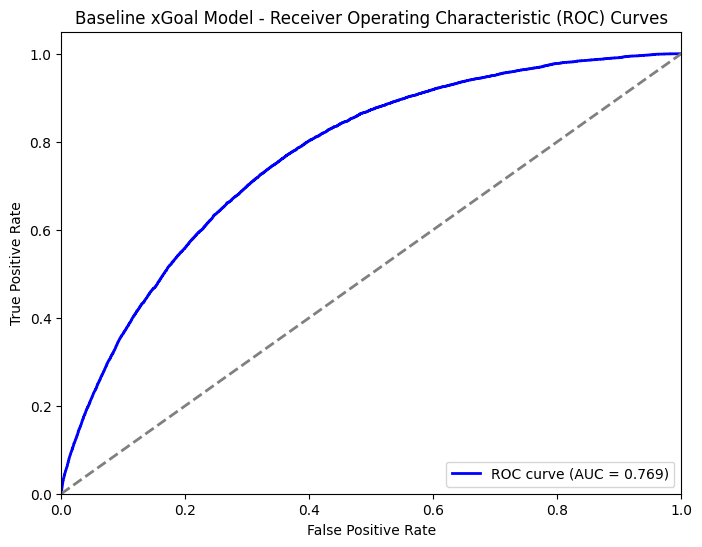

In [224]:
# Split the data into training and testing sets
ev_train_data = EV_PD.sample(frac=0.8, random_state=87)
ev_test_data = EV_PD.drop(ev_train_data.index)

# Define the features, target variable, and cols to exclude
ev_exclude_cols = ['season', 'game_id', 'event_idx']
ev_features = [t_col for t_col in EV_PD.columns if t_col not in ev_exclude_cols and t_col != "is_goal"]

ev_X_train, ev_y_train = ev_train_data[ev_features], ev_train_data["is_goal"]
ev_X_test, ev_y_test = ev_test_data[ev_features], ev_test_data["is_goal"]

# Manually Identify BASELINE Params if Session Stops
baseline_params = {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
ev_baseline_model_sample, ev_y_pred_sample, ev_logloss_sample, ev_auc_sample, ev_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(ev_X_train, ev_y_train, ev_X_test, ev_y_test, baseline_params)

## *Even Strength Model - Year Split*

Baseline xGoal XGBoost Classifier R2 on Test Data: 0.060
Baseline xGoal XGBoost Classifier Log Loss on Test Data: 0.266
Baseline xGoal XGBoost Classifier AUC: 0.751
Baseline xGoal XGBoost Classifier Optimal Treshold: 0.065
Confusion Matrix:
-----------------
[[39299 26337]
 [ 1349  4921]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.60      0.74     65636
           1       0.16      0.78      0.26      6270

    accuracy                           0.61     71906
   macro avg       0.56      0.69      0.50     71906
weighted avg       0.90      0.61      0.70     71906



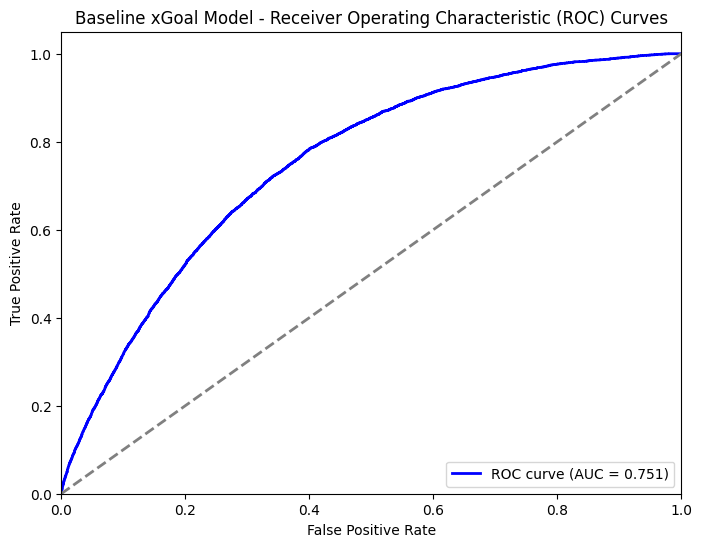

In [225]:
# Split the data into training and testing sets
ev_train_data = EV_PD[EV_PD['season'] <= 2022]
ev_test_data = EV_PD[EV_PD['season'] > 2022]

ev_X_train, ev_y_train = ev_train_data[ev_features], ev_train_data["is_goal"]
ev_X_test, ev_y_test = ev_test_data[ev_features], ev_test_data["is_goal"]

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
ev_baseline_model_year, ev_y_pred_year, ev_logloss_year, ev_auc_year, ev_OT_year = xgboost_trainer.train_and_evaluate_xgboost(ev_X_train, ev_y_train, ev_X_test, ev_y_test, baseline_params)

## *Man-Advantage Model - True Sample*

Baseline xGoal XGBoost Classifier R2 on Test Data: 0.040
Baseline xGoal XGBoost Classifier Log Loss on Test Data: 0.379
Baseline xGoal XGBoost Classifier AUC: 0.686
Baseline xGoal XGBoost Classifier Optimal Treshold: 0.099
Confusion Matrix:
-----------------
[[12051  8203]
 [ 1001  2102]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.92      0.59      0.72     20254
           1       0.20      0.68      0.31      3103

    accuracy                           0.61     23357
   macro avg       0.56      0.64      0.52     23357
weighted avg       0.83      0.61      0.67     23357



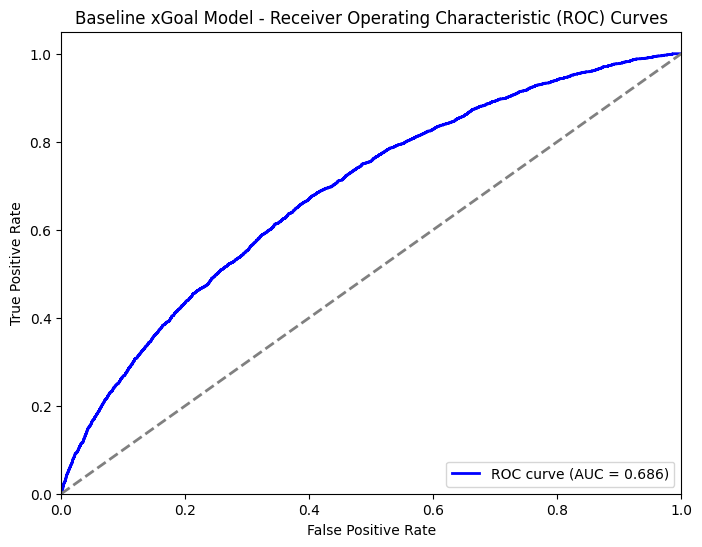

In [226]:
# Split the data into training and testing sets
pp_train_data = PP_PD.sample(frac=0.8, random_state=87)
pp_test_data = PP_PD.drop(pp_train_data.index)

# Define the features, target variable, and cols to exclude
pp_exclude_cols = ['season', 'game_id', 'event_idx']
pp_features = [t_col for t_col in PP_PD.columns if t_col not in pp_exclude_cols and t_col != "is_goal"]

pp_X_train, pp_y_train = pp_train_data[pp_features], pp_train_data["is_goal"]
pp_X_test, pp_y_test = pp_test_data[pp_features], pp_test_data["is_goal"]

# Manually Identify BASELINE Params if Session Stops
baseline_params = {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
pp_baseline_model_sample, pp_y_pred_sample, pp_logloss_sample, pp_auc_sample, pp_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(pp_X_train, pp_y_train, pp_X_test, pp_y_test, baseline_params)

## *Man-Advantage Model - Year Split*

Baseline xGoal XGBoost Classifier R2 on Test Data: -0.000
Baseline xGoal XGBoost Classifier Log Loss on Test Data: 0.394
Baseline xGoal XGBoost Classifier AUC: 0.664
Baseline xGoal XGBoost Classifier Optimal Treshold: 0.110
Confusion Matrix:
-----------------
[[8257 5717]
 [ 766 1429]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.92      0.59      0.72     13974
           1       0.20      0.65      0.31      2195

    accuracy                           0.60     16169
   macro avg       0.56      0.62      0.51     16169
weighted avg       0.82      0.60      0.66     16169



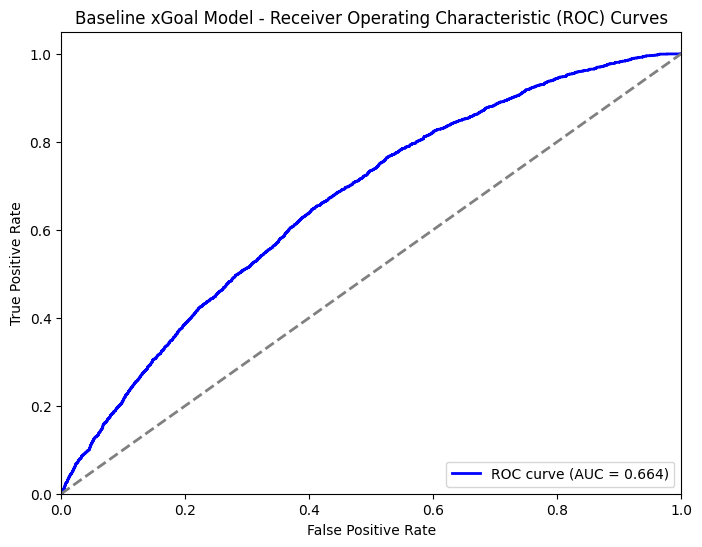

In [227]:
# Split the data into training and testing sets
pp_train_data = PP_PD[PP_PD['season'] <= 2022]
pp_test_data = PP_PD[PP_PD['season'] > 2022]

pp_X_train, pp_y_train = pp_train_data[pp_features], pp_train_data["is_goal"]
pp_X_test, pp_y_test = pp_test_data[pp_features], pp_test_data["is_goal"]

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
pp_baseline_model_year, pp_y_pred_year, pp_logloss_year, pp_auc_year, pp_OT_year = xgboost_trainer.train_and_evaluate_xgboost(pp_X_train, pp_y_train, pp_X_test, pp_y_test, baseline_params)

## *Short Handed Model - True Sample*

Baseline xGoal XGBoost Classifier R2 on Test Data: 0.010
Baseline xGoal XGBoost Classifier Log Loss on Test Data: 0.316
Baseline xGoal XGBoost Classifier AUC: 0.768
Baseline xGoal XGBoost Classifier Optimal Treshold: 0.016
Confusion Matrix:
-----------------
[[3107 1916]
 [  97  397]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.62      0.76      5023
           1       0.17      0.80      0.28       494

    accuracy                           0.64      5517
   macro avg       0.57      0.71      0.52      5517
weighted avg       0.90      0.64      0.71      5517



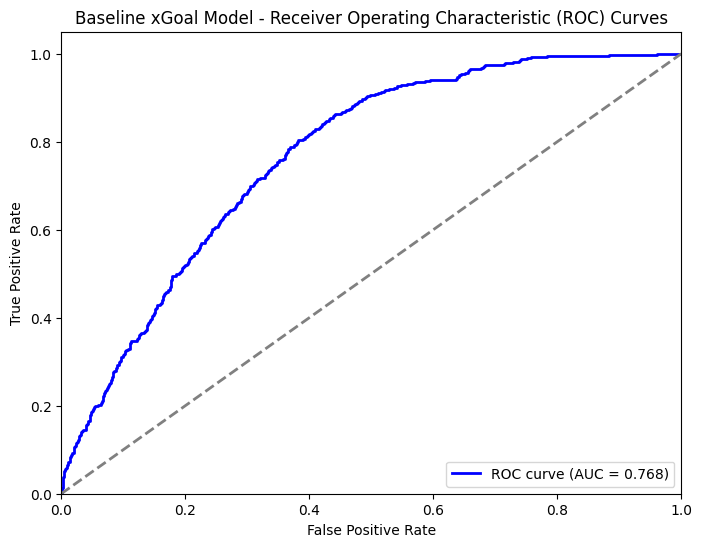

In [228]:
# Split the data into training and testing sets
sh_train_data = SH_PD.sample(frac=0.8, random_state=87)
sh_test_data = SH_PD.drop(sh_train_data.index)

# Define the features, target variable, and cols to exclude
sh_exclude_cols = ['season', 'game_id', 'event_idx']
sh_features = [t_col for t_col in SH_PD.columns if t_col not in sh_exclude_cols and t_col != "is_goal"]

sh_X_train, sh_y_train = sh_train_data[sh_features], sh_train_data["is_goal"]
sh_X_test, sh_y_test = sh_test_data[sh_features], sh_test_data["is_goal"]

# Manually Identify BASELINE Params if Session Stops
baseline_params = {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
sh_baseline_model_sample, sh_y_pred_sample, sh_logloss_sample, sh_auc_sample, sh_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(sh_X_train, sh_y_train, sh_X_test, sh_y_test, baseline_params)

## *Short Handed Model - Year Split*

Baseline xGoal XGBoost Classifier R2 on Test Data: -0.020
Baseline xGoal XGBoost Classifier Log Loss on Test Data: 0.317
Baseline xGoal XGBoost Classifier AUC: 0.796
Baseline xGoal XGBoost Classifier Optimal Treshold: 0.017
Confusion Matrix:
-----------------
[[1563  942]
 [  30  238]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.98      0.62      0.76      2505
           1       0.20      0.89      0.33       268

    accuracy                           0.65      2773
   macro avg       0.59      0.76      0.55      2773
weighted avg       0.91      0.65      0.72      2773



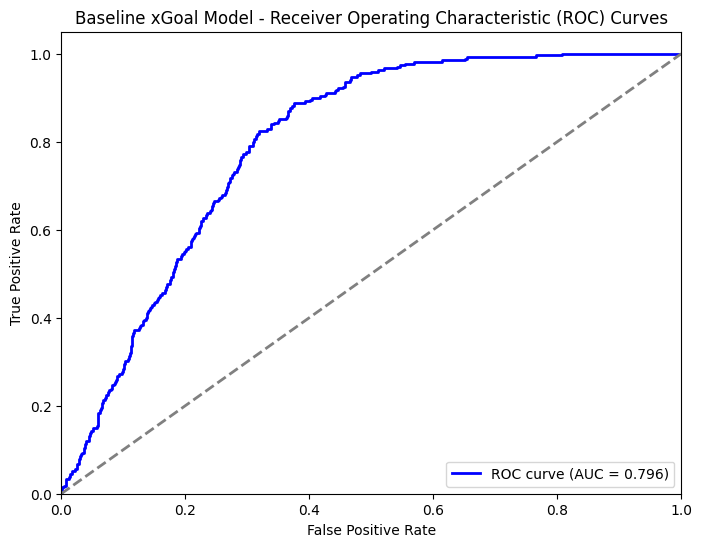

In [229]:
# Split the data into training and testing sets
sh_train_data = SH_PD[SH_PD['season'] <= 2022]
sh_test_data = SH_PD[SH_PD['season'] > 2022]

sh_X_train, sh_y_train = sh_train_data[sh_features], sh_train_data["is_goal"]
sh_X_test, sh_y_test = sh_test_data[sh_features], sh_test_data["is_goal"]

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
sh_baseline_model_year, sh_y_pred_year, sh_logloss_year, sh_auc_year, sh_OT_year = xgboost_trainer.train_and_evaluate_xgboost(sh_X_train, sh_y_train, sh_X_test, sh_y_test, baseline_params)

## *Empty Net Model - True Sample*

Baseline xGoal XGBoost Classifier R2 on Test Data: -0.020
Baseline xGoal XGBoost Classifier Log Loss on Test Data: 0.317
Baseline xGoal XGBoost Classifier AUC: 0.796
Baseline xGoal XGBoost Classifier Optimal Treshold: 0.017
Confusion Matrix:
-----------------
[[1563  942]
 [  30  238]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.98      0.62      0.76      2505
           1       0.20      0.89      0.33       268

    accuracy                           0.65      2773
   macro avg       0.59      0.76      0.55      2773
weighted avg       0.91      0.65      0.72      2773



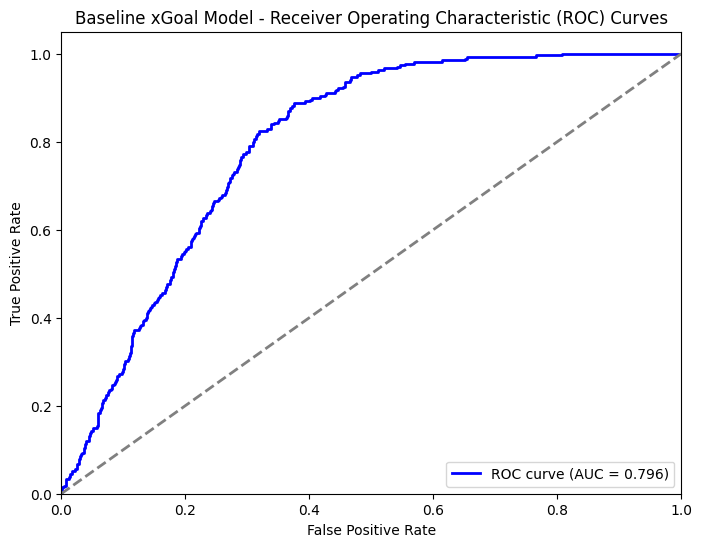

In [230]:
# Split the data into training and testing sets
en_train_data = EN_PD.sample(frac=0.8, random_state=87)
en_test_data = EN_PD.drop(en_train_data.index)

# Define the features, target variable, and cols to exclude
en_exclude_cols = ['season', 'game_id', 'event_idx']
en_features = [t_col for t_col in EN_PD.columns if t_col not in en_exclude_cols and t_col != "is_goal"]

en_X_train, en_y_train = en_train_data[en_features], en_train_data["is_goal"]
en_X_test, en_y_test = en_test_data[en_features], en_test_data["is_goal"]

# Manually Identify BASELINE Params if Session Stops
baseline_params = {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
en_baseline_model_sample, en_y_pred_sample, en_logloss_sample, en_auc_sample, en_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(sh_X_train, sh_y_train, sh_X_test, sh_y_test, baseline_params)

## *Empty Net Model - Year Split*

Baseline xGoal XGBoost Classifier R2 on Test Data: 0.850
Baseline xGoal XGBoost Classifier Log Loss on Test Data: 0.179
Baseline xGoal XGBoost Classifier AUC: 0.979
Baseline xGoal XGBoost Classifier Optimal Treshold: 0.924
Confusion Matrix:
-----------------
[[346   0]
 [ 32 471]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       346
           1       1.00      0.94      0.97       503

    accuracy                           0.96       849
   macro avg       0.96      0.97      0.96       849
weighted avg       0.97      0.96      0.96       849



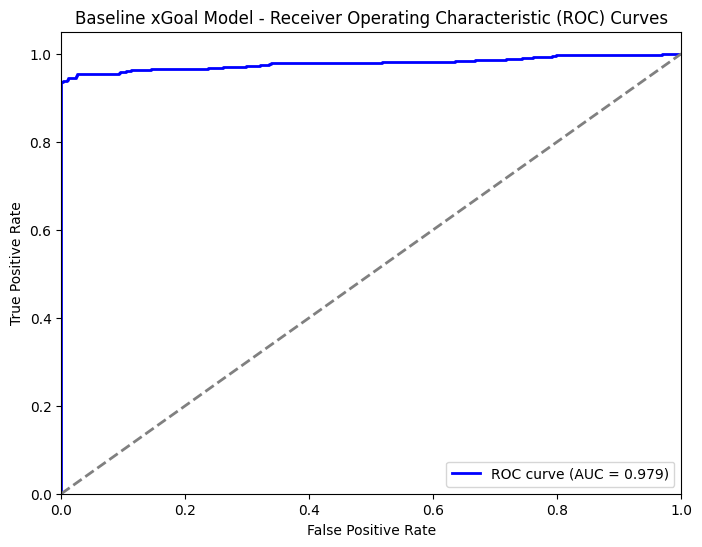

In [231]:
# Split the data into training and testing sets
en_train_data = EN_PD[EN_PD['season'] <= 2022]
en_test_data = EN_PD[EN_PD['season'] > 2022]

en_X_train, en_y_train = en_train_data[en_features], en_train_data["is_goal"]
en_X_test, en_y_test = en_test_data[en_features], en_test_data["is_goal"]

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
en_baseline_model_year, en_y_pred_year, en_logloss_year, en_auc_year, en_OT_year = xgboost_trainer.train_and_evaluate_xgboost(en_X_train, en_y_train, en_X_test, en_y_test, baseline_params)

## Hypertune Parameters

Here, I want to hypertune my parameters and use the most current data as the test rather than a sample. If hypertuning is able to help the model be more predictive on the most current data (rather than testing against a sample of data that includes 2012-2013 data), then it will likely be more predictive in the future.

In [235]:
# Optimize hyperparameters
hyperparameter_optimizer = HyperparameterOptimizer(n_startup_trials=10000, n_trials=500)
alt_hyperparameter_optimizer = HyperparameterOptimizer(n_startup_trials=1000, n_trials=100)

# EV - Max Depth = 4
print("Begin Even Strength Hypertuning")
ev_best_params, ev_param_df = hyperparameter_optimizer.optimize_hyperparameters(ev_X_train, ev_y_train, ev_X_test, ev_y_test, type = 'EV')

# PP
print("Begin Man Advantage Hypertuning")
#pp_best_params, pp_param_df = hyperparameter_optimizer.optimize_hyperparameters(pp_X_train, pp_y_train, pp_X_test, pp_y_test, type = 'PP')

# SH
print("Begin Shorthanded Hypertuning")
#sh_best_params, sh_param_df = alt_hyperparameter_optimizer.optimize_hyperparameters(sh_X_train, sh_y_train, sh_X_test, sh_y_test, type = 'SH')

# EN
print("Begin Empty Net Hypertuning")
#en_best_params, en_param_df = alt_hyperparameter_optimizer.optimize_hyperparameters(en_X_train, en_y_train, en_X_test, en_y_test, type = 'EN')

[I 2023-11-27 10:34:57,762] A new study created in memory with name: XGBoost Classification Optimization


Begin Even Strength Hypertuning


[I 2023-11-27 10:35:08,388] Trial 0 finished with value: 0.2597170028551768 and parameters: {'max_depth': 5, 'learning_rate': 0.050022654997035454, 'n_estimators': 661, 'min_child_weight': 5, 'reg_alpha': 7, 'reg_lambda': 7, 'gamma': 0.02305289256575309, 'seed': 87, 'max_delta_step': 5, 'colsample_bytree': 0.8378654107771919, 'subsample': 0.7996557879366194}. Best is trial 0 with value: 0.2597170028551768.
[I 2023-11-27 10:35:17,822] Trial 1 finished with value: 0.25970470084868286 and parameters: {'max_depth': 5, 'learning_rate': 0.050281121983994516, 'n_estimators': 610, 'min_child_weight': 5, 'reg_alpha': 6, 'reg_lambda': 6, 'gamma': 0.016614756335309698, 'seed': 87, 'max_delta_step': 5, 'colsample_bytree': 0.8408057524982944, 'subsample': 0.7837974438239725}. Best is trial 1 with value: 0.25970470084868286.
[I 2023-11-27 10:35:28,604] Trial 2 finished with value: 0.2598684231856305 and parameters: {'max_depth': 5, 'learning_rate': 0.052456535469830805, 'n_estimators': 714, 'min_chi

In [233]:
ev_param_df.sort_values('value').head(10)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_delta_step,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_seed,params_subsample,state
186,186,0.259832,2023-11-26 19:45:41.775188,2023-11-26 19:45:55.609927,0 days 00:00:13.834739,0.75,0.028995,0.050827,5,5,5,874,7,7,87,0.75,COMPLETE
115,115,0.259845,2023-11-26 19:29:26.628518,2023-11-26 19:29:36.568334,0 days 00:00:09.939816,0.75,0.021949,0.050406,5,5,5,630,5,5,87,0.75,COMPLETE
125,125,0.259845,2023-11-26 19:31:34.183789,2023-11-26 19:31:45.814062,0 days 00:00:11.630273,0.75,0.023564,0.050139,5,5,5,763,5,6,87,0.75,COMPLETE
167,167,0.259859,2023-11-26 19:41:21.549291,2023-11-26 19:41:30.834785,0 days 00:00:09.285494,0.75,0.029249,0.057966,5,5,5,600,4,5,87,0.75,COMPLETE
152,152,0.259863,2023-11-26 19:37:53.084190,2023-11-26 19:38:03.549897,0 days 00:00:10.465707,0.75,0.020963,0.054233,5,5,5,672,4,5,87,0.75,COMPLETE
198,198,0.259864,2023-11-26 19:48:39.315654,2023-11-26 19:48:48.580781,0 days 00:00:09.265127,0.75,0.015773,0.068337,5,5,5,615,5,3,87,0.75,COMPLETE
135,135,0.259866,2023-11-26 19:33:46.880402,2023-11-26 19:33:59.842940,0 days 00:00:12.962538,0.75,0.029395,0.057357,5,5,5,854,5,3,87,0.75,COMPLETE
264,264,0.259876,2023-11-26 20:12:55.772923,2023-11-26 20:13:07.184068,0 days 00:00:11.411145,0.75,0.010648,0.054150,5,5,5,722,5,3,87,0.75,COMPLETE
332,332,0.259889,2023-11-26 20:29:49.931474,2023-11-26 20:34:59.901363,0 days 00:05:09.969889,0.75,0.024060,0.051857,5,5,5,645,4,6,87,0.75,COMPLETE
247,247,0.259894,2023-11-26 20:08:52.427085,2023-11-26 20:09:02.662362,0 days 00:00:10.235277,0.75,0.010116,0.052635,5,5,5,633,7,7,87,0.75,COMPLETE


## Optimized Even Strength Model

Optimized xGoal XGBoost Classifier R2 on Test Data: 0.080
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.260
Optimized xGoal XGBoost Classifier AUC: 0.762
Optimized xGoal XGBoost Classifier Optimal Treshold: 0.082
Confusion Matrix:
-----------------
[[42272 23362]
 [ 1520  4751]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.64      0.77     65634
           1       0.17      0.76      0.28      6271

    accuracy                           0.65     71905
   macro avg       0.57      0.70      0.52     71905
weighted avg       0.90      0.65      0.73     71905



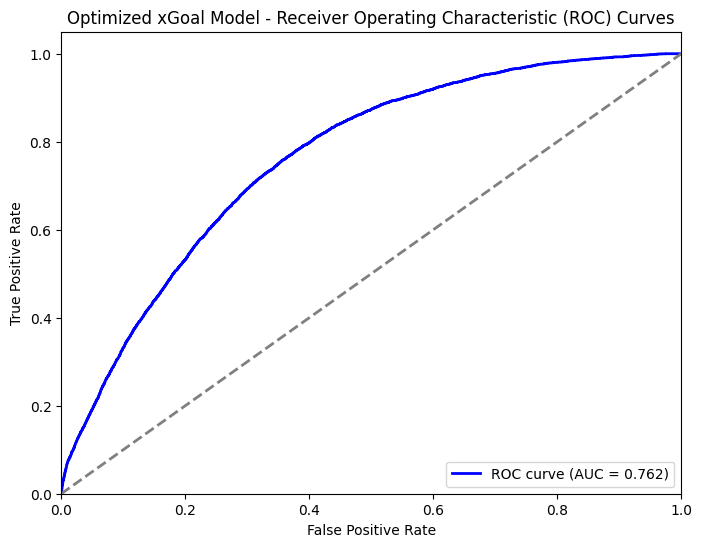

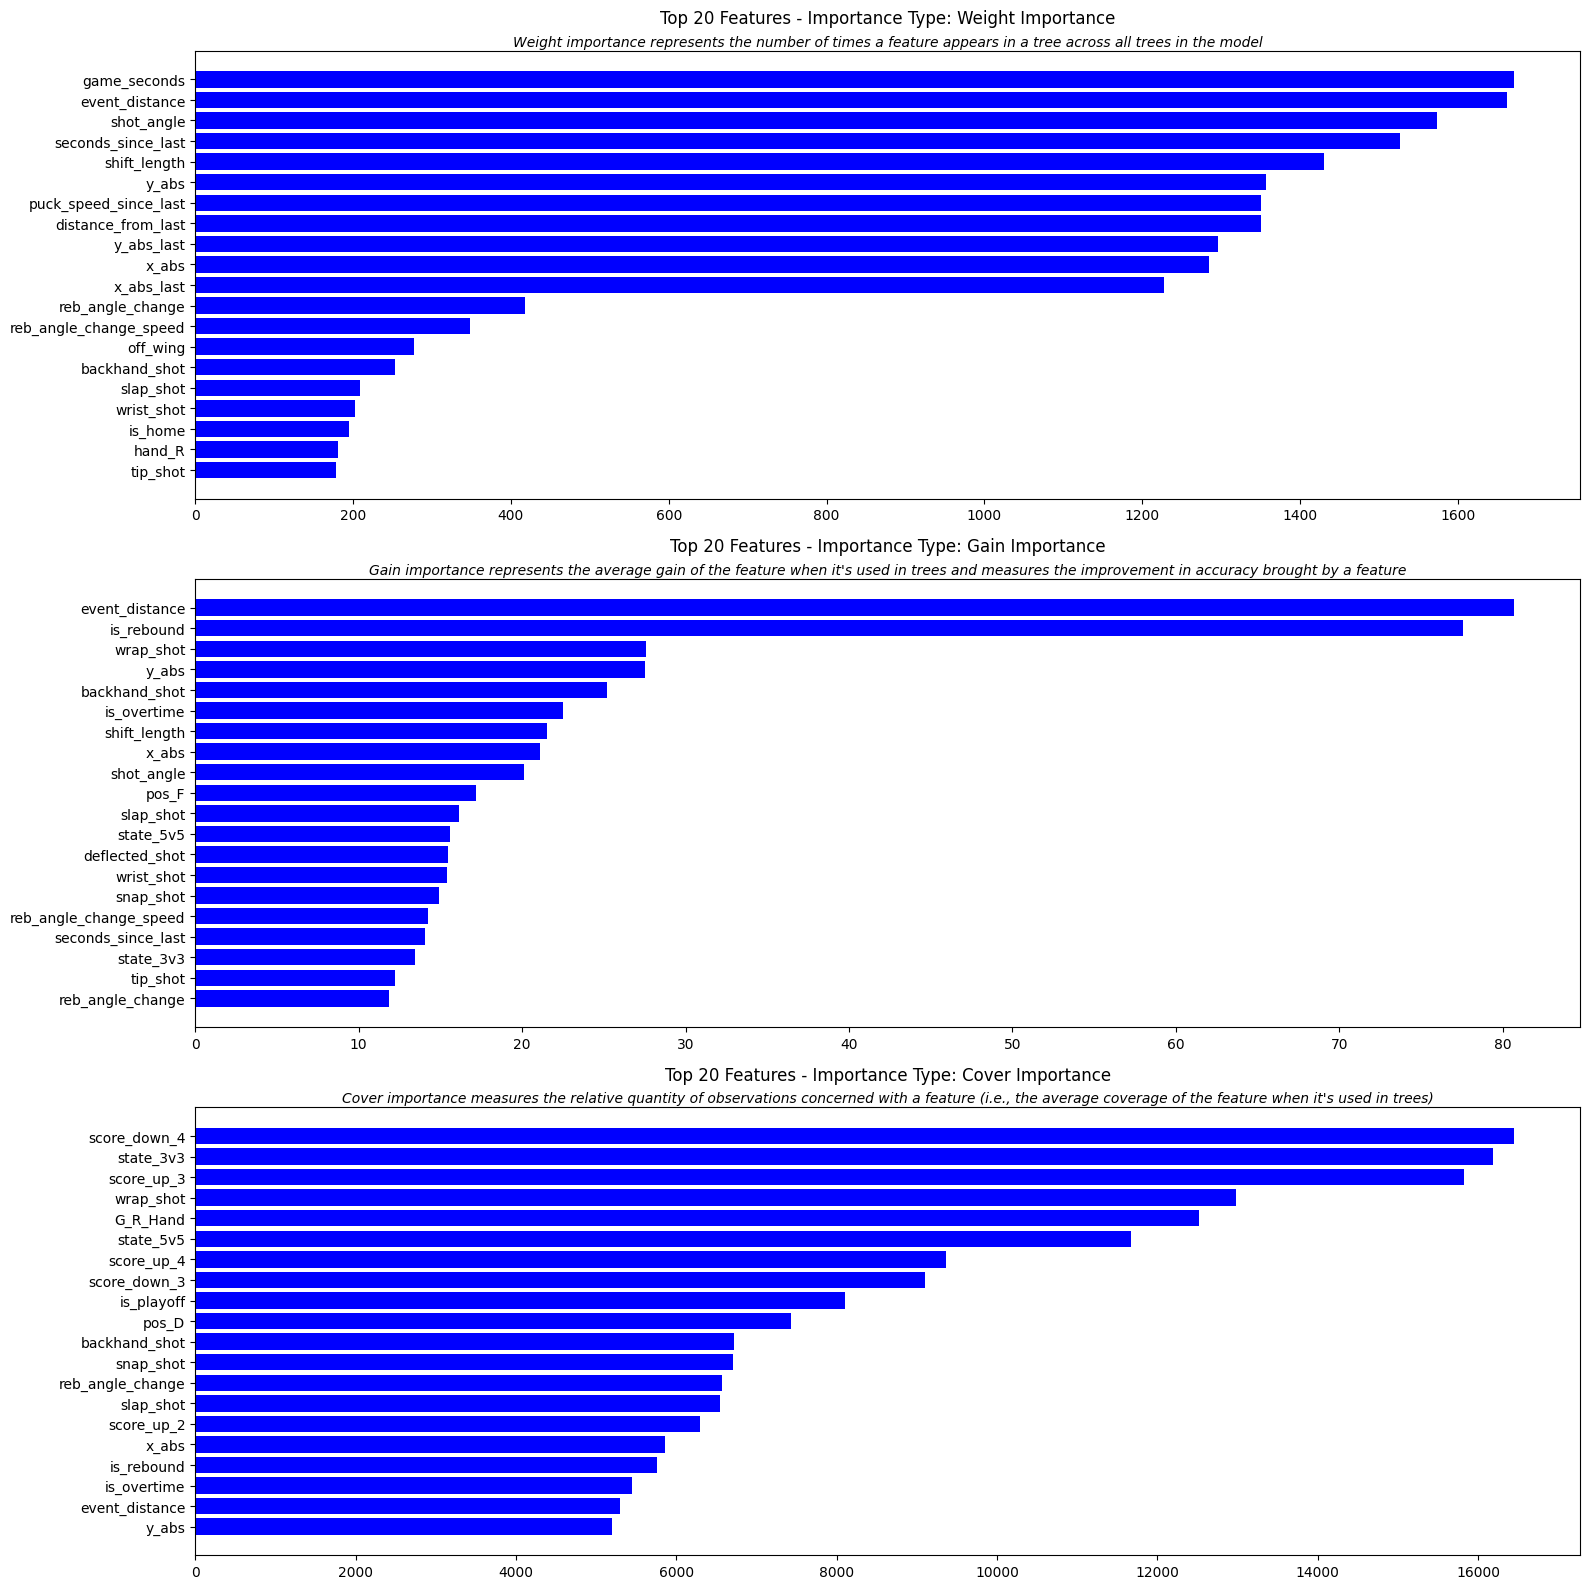

In [98]:
# Train HyperTuned Model
xgboost_trainer = XGBoostTrainer()
best_ev_model, y_pred_ev, best_ev_logloss, best_ev_auc, best_ev_OT = xgboost_trainer.train_and_evaluate_xgboost(ev_X_train, ev_y_train, ev_X_test, ev_y_test, ev_best_params)

# Return Feature Analysis Plot
Feature_Analysis().plot_top_features(best_ev_model, 20)

## Optimized Man-Advantage Model

Optimized xGoal XGBoost Classifier R2 on Test Data: 0.060
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.368
Optimized xGoal XGBoost Classifier AUC: 0.701
Optimized xGoal XGBoost Classifier Optimal Treshold: 0.127
Confusion Matrix:
-----------------
[[8309 5663]
 [ 643 1552]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.93      0.59      0.72     13972
           1       0.22      0.71      0.33      2195

    accuracy                           0.61     16167
   macro avg       0.57      0.65      0.53     16167
weighted avg       0.83      0.61      0.67     16167



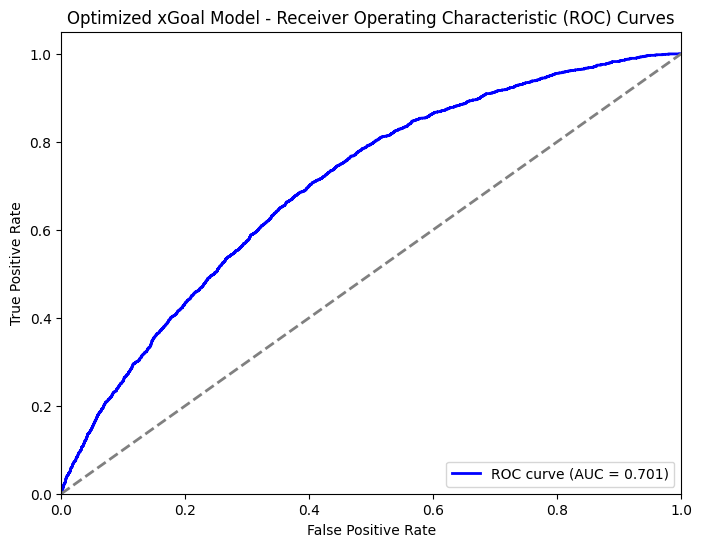

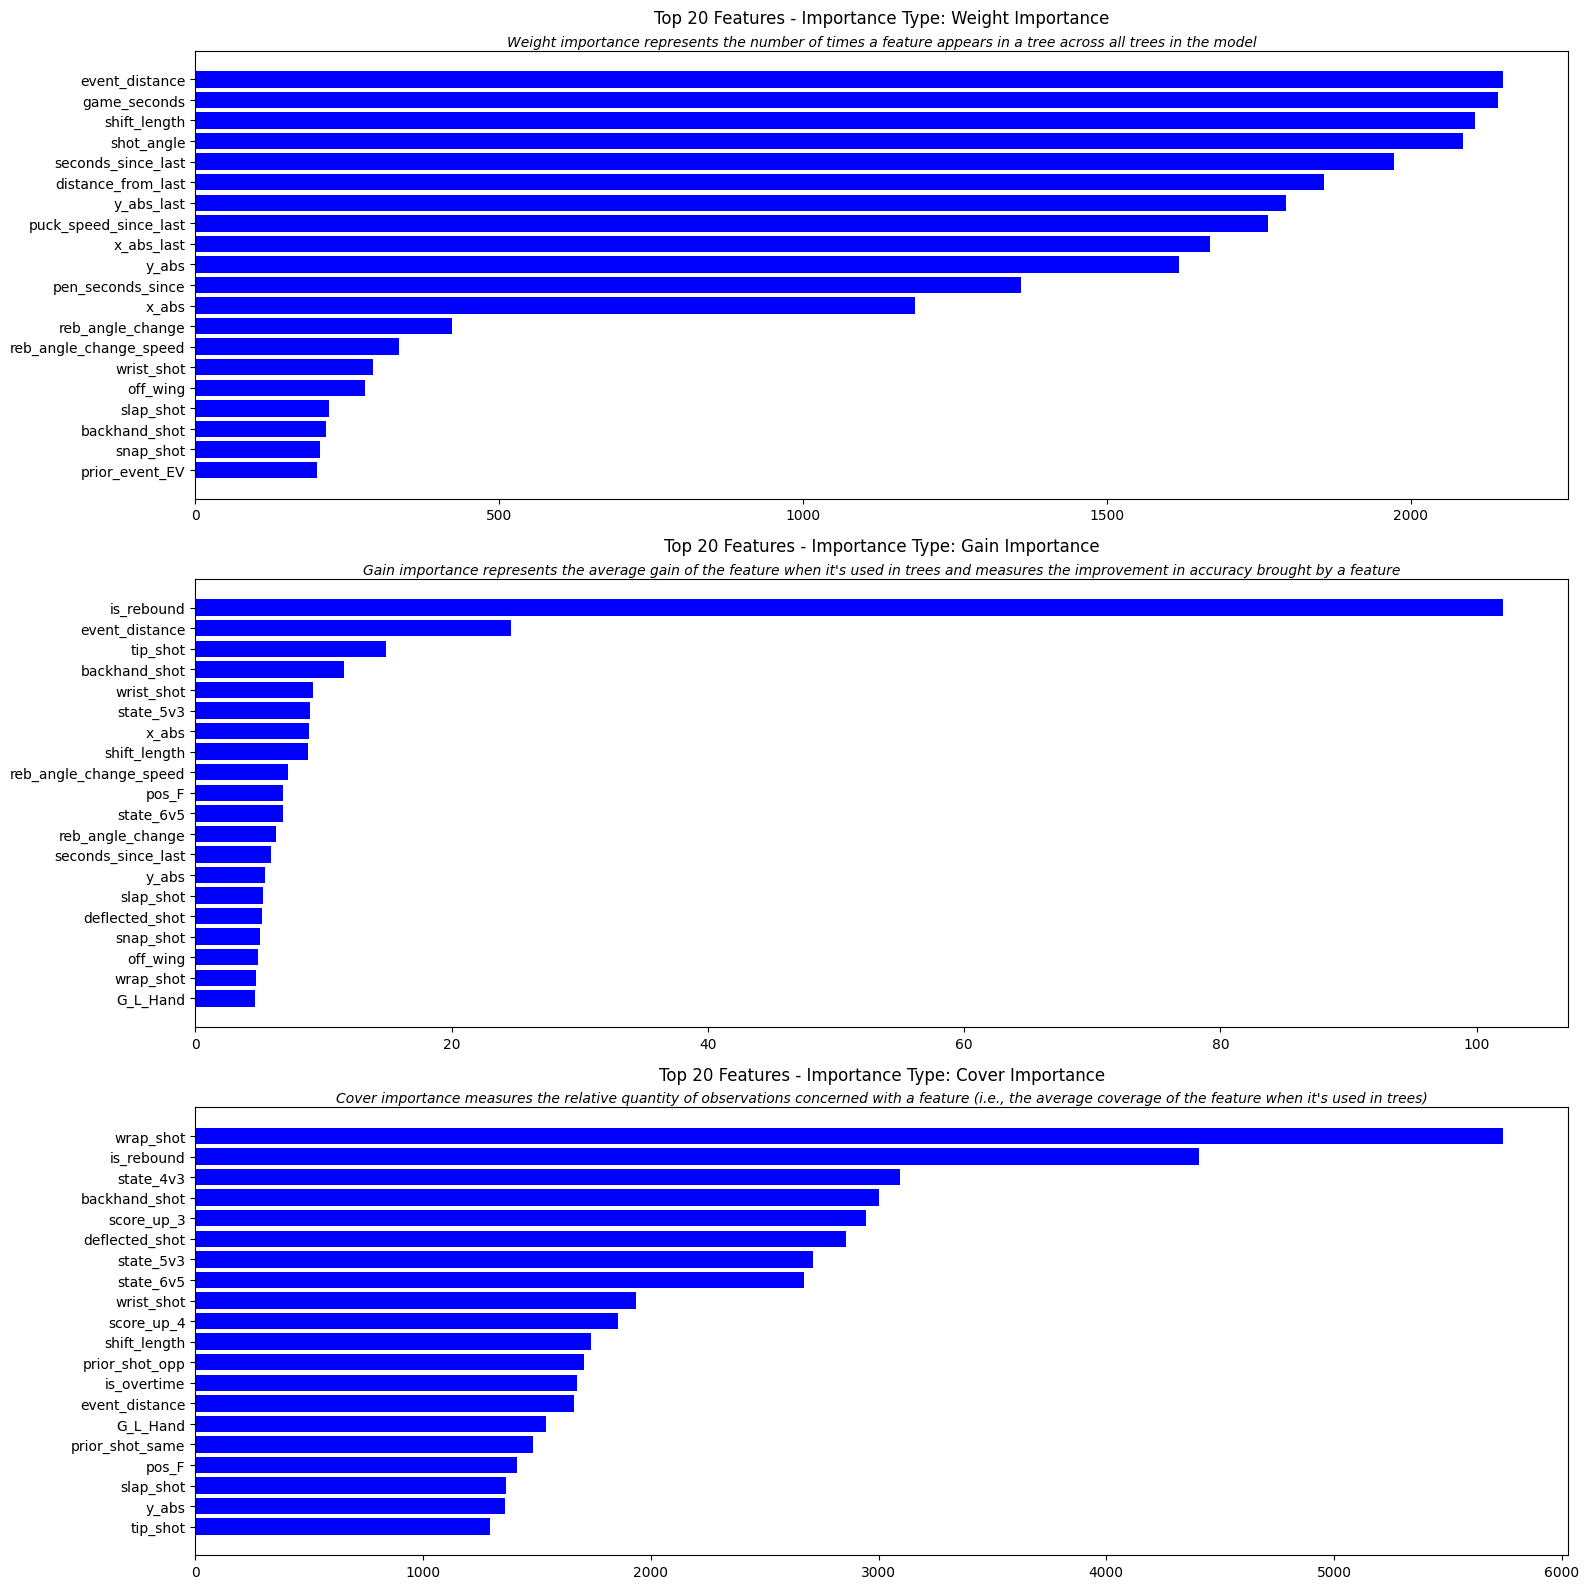

In [77]:
# Train HyperTuned Model
best_pp_model, y_pred_pp, best_pp_logloss, best_pp_auc, best_pp_OT = xgboost_trainer.train_and_evaluate_xgboost(pp_X_train, pp_y_train, pp_X_test, pp_y_test, pp_best_params)

# Return Feature Analysis Plot
Feature_Analysis().plot_top_features(best_pp_model, 20)

## Optimized Short-Handed Model

Optimized xGoal XGBoost Classifier R2 on Test Data: 0.120
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.217
Optimized xGoal XGBoost Classifier AUC: 0.828
Optimized xGoal XGBoost Classifier Optimal Treshold: 0.068
Confusion Matrix:
-----------------
[[2267 1051]
 [  45  231]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.98      0.68      0.81      3318
           1       0.18      0.84      0.30       276

    accuracy                           0.70      3594
   macro avg       0.58      0.76      0.55      3594
weighted avg       0.92      0.70      0.77      3594



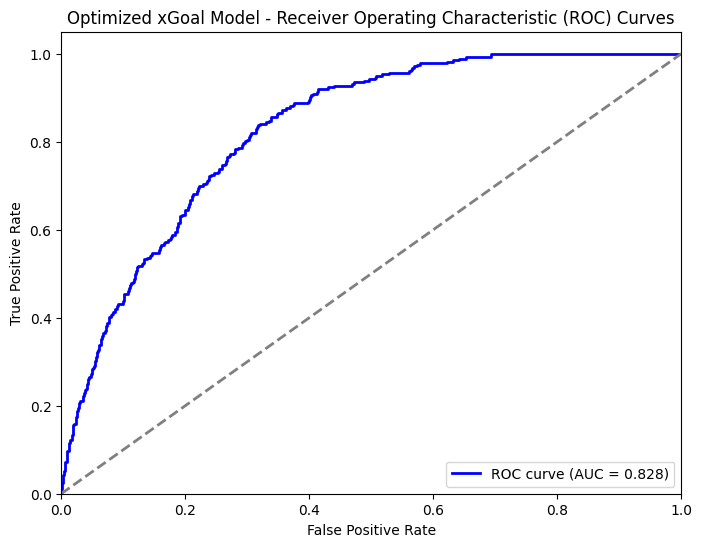

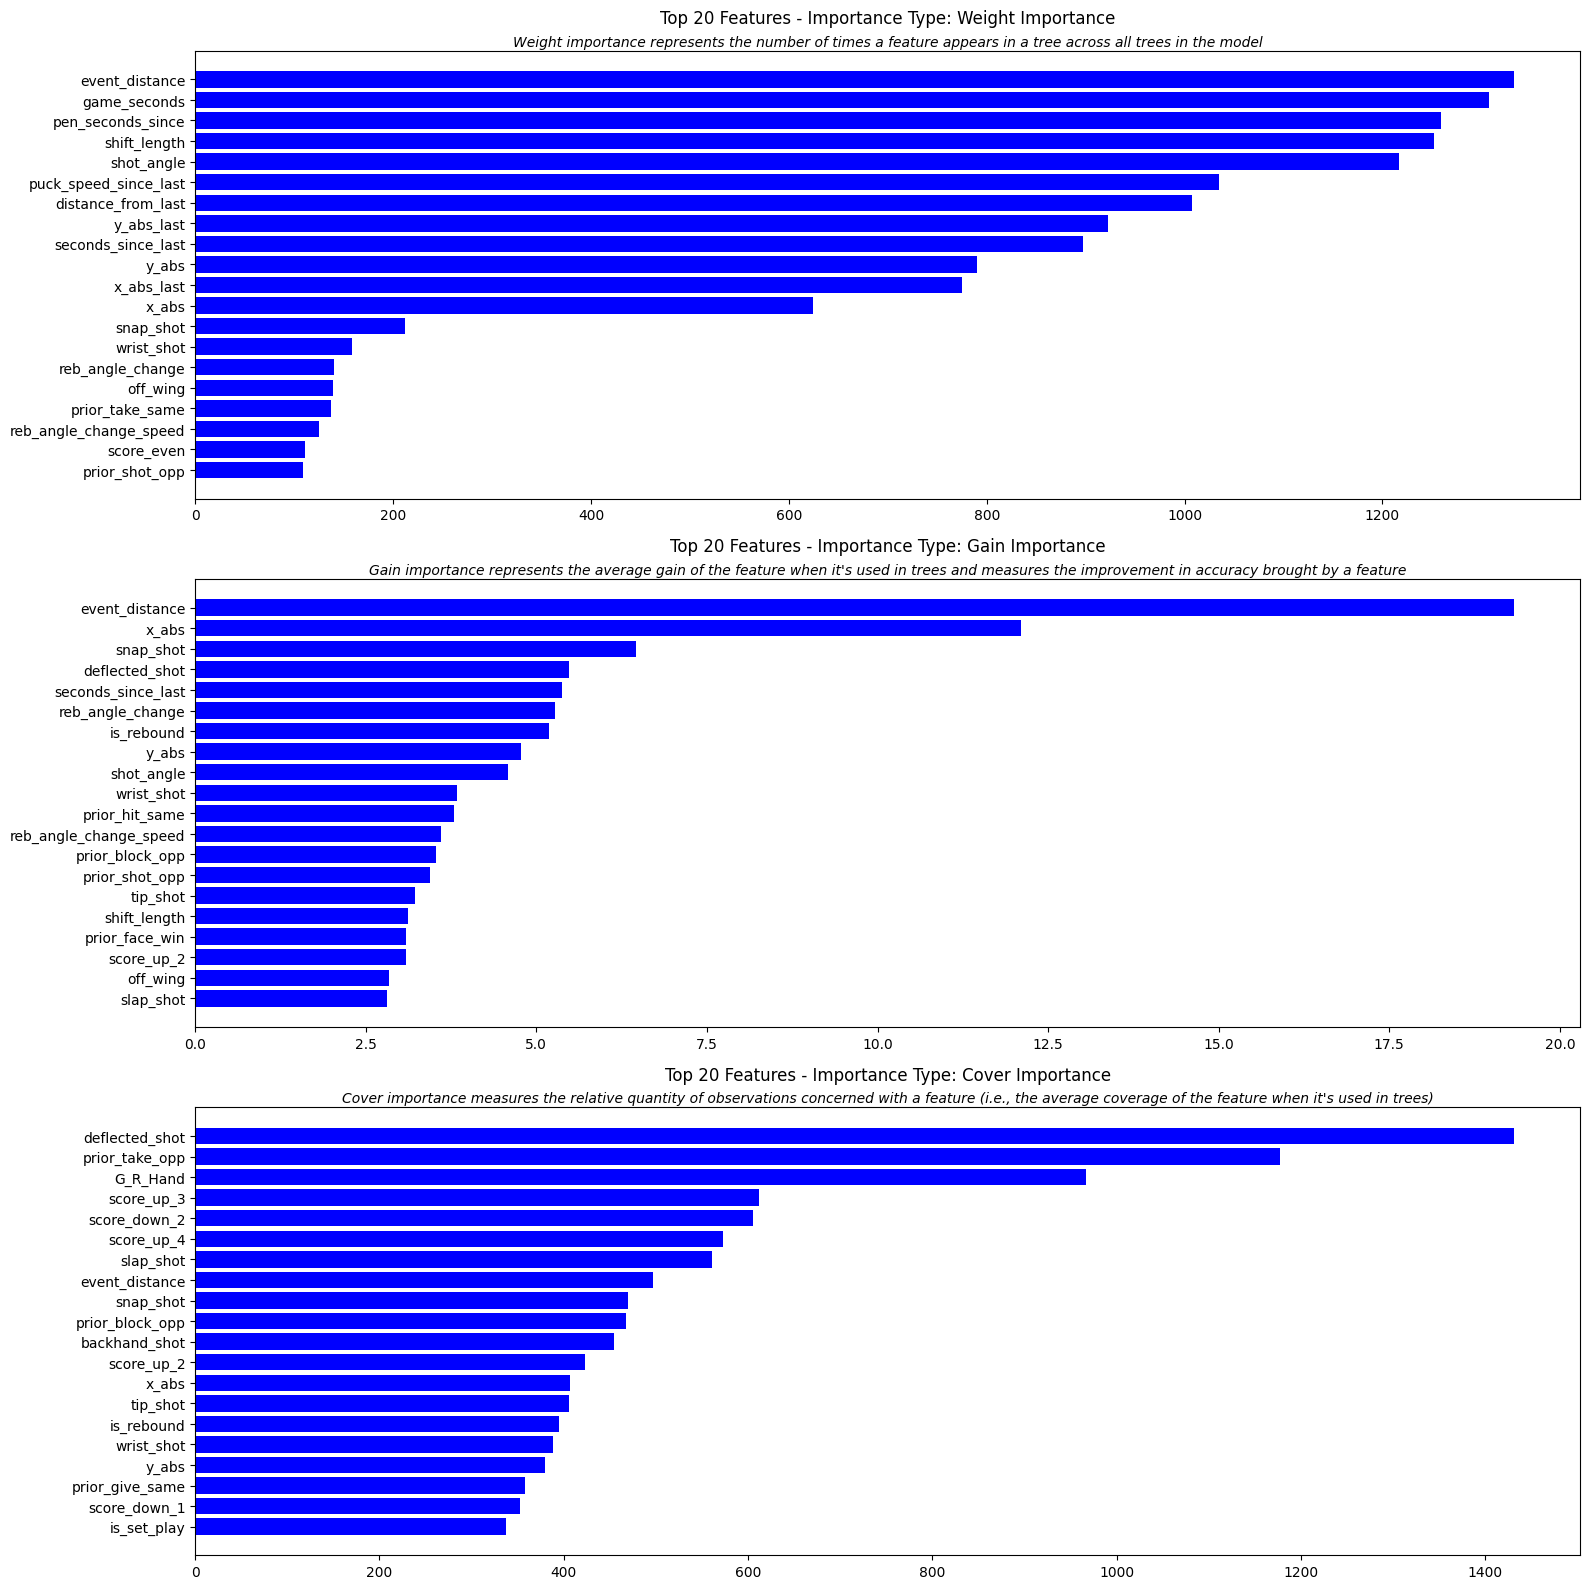

In [28]:
# Train HyperTuned Model
best_sh_model, y_pred_sh, best_sh_logloss, best_sh_auc, best_sh_OT = xgboost_trainer.train_and_evaluate_xgboost(sh_X_train, sh_y_train, sh_X_test, sh_y_test, sh_best_params)

# Return Feature Analysis Plot
Feature_Analysis().plot_top_features(best_sh_model, 20)

## Optimized Empty Net Model

Optimized xGoal XGBoost Classifier R2 on Test Data: 0.860
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.129
Optimized xGoal XGBoost Classifier AUC: 0.982
Optimized xGoal XGBoost Classifier Optimal Treshold: 0.593
Confusion Matrix:
-----------------
[[345   0]
 [ 28 475]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       345
           1       1.00      0.94      0.97       503

    accuracy                           0.97       848
   macro avg       0.96      0.97      0.97       848
weighted avg       0.97      0.97      0.97       848



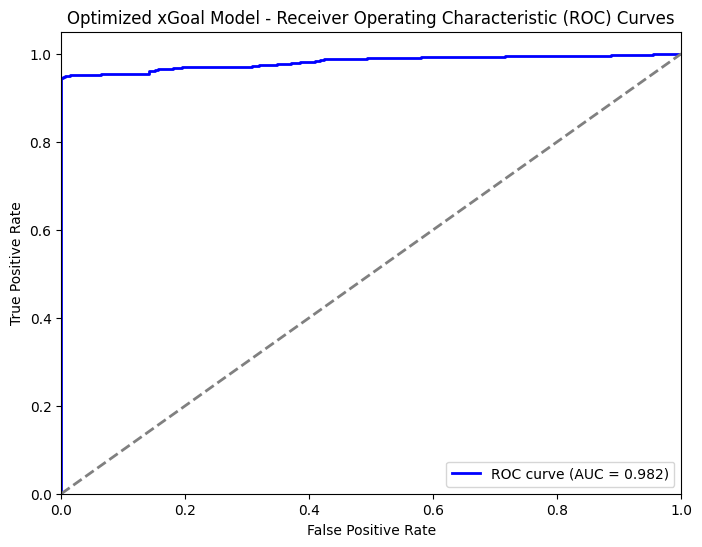

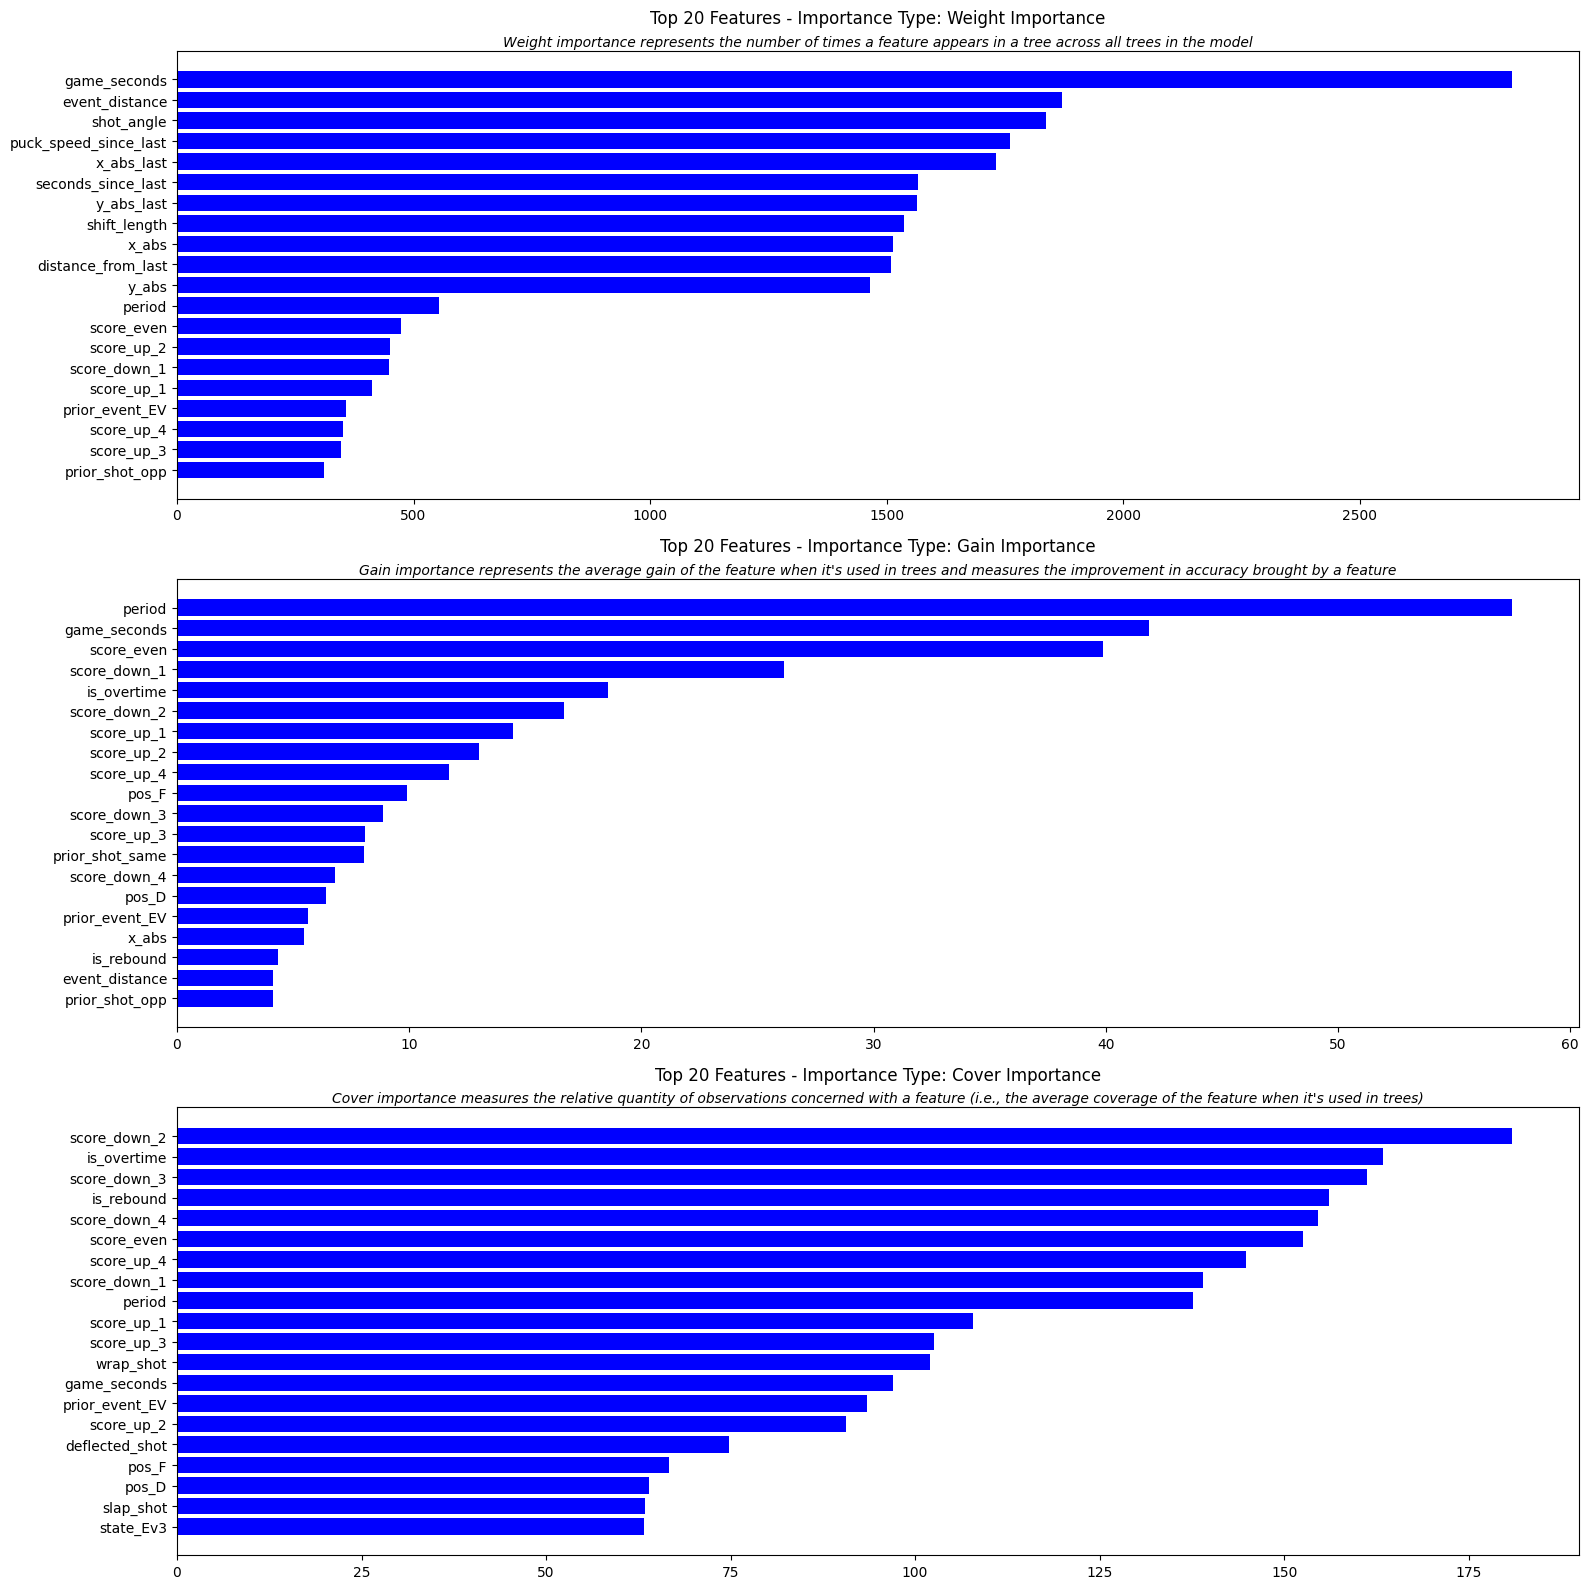

In [29]:
# Train HyperTuned Model
best_en_model, y_pred_en, best_en_logloss, best_en_auc, best_en_OT = xgboost_trainer.train_and_evaluate_xgboost(en_X_train, en_y_train, en_X_test, en_y_test, en_best_params)

# Return Feature Analysis Plot
Feature_Analysis().plot_top_features(best_en_model, 20)

## Analyze Accuracy Metrics

In [30]:
analysis_df = pd.DataFrame({
    'Strength_Type': ['EV', 'EV', 'EV', 'PP', 'PP', 'PP', 'SH', 'SH', 'SH', 'EN', 'EN', 'EN'],
    'Test_Type': ['Sample', 'Current', 'Optimized','Sample', 'Current', 'Optimized','Sample', 'Current', 'Optimized','Sample', 'Current', 'Optimized'],
    'Log_Loss': [ev_logloss_sample, ev_logloss_year, best_ev_logloss, pp_logloss_sample, pp_logloss_year, best_pp_logloss, sh_logloss_sample, sh_logloss_year, best_sh_logloss, en_logloss_sample, en_logloss_year, best_en_logloss],
    'AUC': [ev_auc_sample, ev_auc_year, best_ev_auc,  pp_auc_sample, pp_auc_year, best_pp_auc, sh_auc_sample, sh_auc_year, best_sh_auc, en_auc_sample, en_auc_year, best_en_auc],
    'Optimal_Threshold': [ev_OT_sample, ev_OT_year, best_ev_OT, pp_OT_sample, pp_OT_year, best_pp_OT, sh_OT_sample, sh_OT_year, best_sh_OT, en_OT_sample, en_OT_year, best_en_OT],
})

print(analysis_df)

   Strength_Type  Test_Type  Log_Loss       AUC  Optimal_Threshold
0             EV     Sample  0.188664  0.799478           0.052216
1             EV    Current  0.203648  0.779569           0.058856
2             EV  Optimized  0.200226  0.786254           0.057362
3             PP     Sample  0.268222  0.761599           0.093626
4             PP    Current  0.286720  0.750988           0.060456
5             PP  Optimized  0.278704  0.760819           0.090210
6             SH     Sample  0.251084  0.785590           0.012340
7             SH    Current  0.265746  0.796958           0.010506
8             SH  Optimized  0.216895  0.828055           0.068220
9             EN     Sample  0.265746  0.796958           0.010506
10            EN    Current  0.186500  0.977883           0.687185
11            EN  Optimized  0.129433  0.981571           0.593488


# 3) Apply Model

In [31]:
# Filter Test Seasons
EV_DF = EV_PD[EV_PD['season'] > 2022]
PP_DF = PP_PD[PP_PD['season'] > 2022]
SH_DF = SH_PD[SH_PD['season'] > 2022]
EN_DF = EN_PD[EN_PD['season'] > 2022]

## Add xGoals and Model Type
#EV_DF['xG'] = y_pred_ev
#PP_DF['xG'] = y_pred_pp
#SH_DF['xG'] = y_pred_sh
#EN_DF['xG'] = y_pred_en
#
#EV_DF['model_type'] = pd.lit('EV')
#PP_DF['model_type'] = pd.lit('PP')
#SH_DF['model_type'] = pd.lit('SH')
#EN_DF['model_type'] = pd.lit('EN')

# Add xGoals and Model Type using assign
EV_DF = EV_DF.assign(xG=y_pred_ev, model_type='EV')
PP_DF = PP_DF.assign(xG=y_pred_pp, model_type='PP')
SH_DF = SH_DF.assign(xG=y_pred_sh, model_type='SH')
EN_DF = EN_DF.assign(xG=y_pred_en, model_type='EN', reb_angle_change=0.0, reb_angle_change_speed=0.0).astype({'reb_angle_change': 'float64', 'reb_angle_change_speed': 'float64'})

# Select Relevant Features
keep_cols = ['season', 'game_id', 'event_idx', 'model_type', 'xG', 'is_goal',
             'event_distance', 'shot_angle', 'x_abs', 'y_abs',
             'is_set_play', 'is_rebound', 'reb_angle_change', 'reb_angle_change_speed',
             'off_wing', 'hand_R', 'hand_L', 'pos_F', 'pos_D', 'pos_G', 'prior_shot_same',
             'is_rush_play', 'seconds_since_last', 'puck_speed_since_last']
EV_DF = EV_DF[keep_cols]
PP_DF = PP_DF[keep_cols]
SH_DF = SH_DF[keep_cols]
EN_DF = EN_DF[keep_cols]


# To Polars
EV_DF = pl.DataFrame(EV_DF)
PP_DF = pl.DataFrame(PP_DF)
SH_DF = pl.DataFrame(SH_DF)
EN_DF = pl.DataFrame(EN_DF)

# Combine
df_list = [EV_DF, PP_DF, SH_DF, EN_DF]

PRED = df_list[0]
for df in df_list[1:]:
    PRED = PRED.extend(df)
print(str(PRED.height) + " Total Shots in Prediction DF")

PBP = sdv.nhl.load_nhl_pbp(seasons=range(2023,2024)).select(nhl_pbp_cols).extend(sdv.nhl.load_nhl_pbp(seasons=range(2024,2025)).select(nhl_pbp_cols))
print("Max Date:", PBP['game_date'].str.to_date().max())

PBP_xG = PBP.join(PRED, on = ['season','game_id','event_idx'], how= "inner")

134560 Total Shots in Prediction DF


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Max Date: 2023-11-06


## Save Results and Analysis DF

In [32]:
PBP_xG.head()
#PBP_xG['reb_angle_change_speed'].max()

## Network X Package

event_type,event,description,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,strength_state,event_idx,extra_attacker,home_skaters,away_skaters,game_id,period_type,ordinal_num,period_time,period_time_remaining,date_time,home_final,away_final,season,season_type,game_date,game_start,game_end,game_length,game_state,detailed_state,venue_name,venue_link,home_name,home_abbreviation,home_division_name,home_conference_name,home_id,away_name,away_abbreviation,away_division_name,away_conference_name,away_id,event_id,event_team,event_team_type,num_on,players_on,players_off,away_on_1,away_on_2,away_on_3,away_on_4,away_on_5,away_goalie,ids_on,ids_off,secondary_type,home_on_1,home_on_2,home_on_3,home_on_4,home_on_5,home_goalie,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,strength,x,y,x_fixed,y_fixed,event_player_1_id,event_player_1_link,event_player_2_id,event_player_2_link,event_team_id,event_team_link,event_team_abbr,num_off,penalty_severity,penalty_minutes,away_on_6,shot_distance,shot_angle,event_goalie_name,event_goalie_id,event_goalie_link,event_goalie_type,event_player_3_name,event_player_3_type,game_winning_goal,empty_net,event_player_3_id,event_player_3_link,event_player_4_type,event_player_4_id,event_player_4_name,event_player_4_link,home_on_6,venue_id,model_type,xG,is_goal,event_distance,shot_angle_right,x_abs,y_abs,is_set_play,is_rebound,reb_angle_change,reb_angle_change_speed,off_wing,hand_R,hand_L,pos_F,pos_D,pos_G,prior_shot_same,is_rush_play,seconds_since_last,puck_speed_since_last
str,str,str,i32,i32,i32,i32,i32,i32,i32,str,str,bool,i32,i32,i32,str,str,str,str,str,i32,i32,i32,str,str,str,str,i32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,i32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,i32,i32,i32,i32,str,i32,str,i32,str,str,i32,str,i32,str,f64,f64,str,i32,str,str,str,str,bool,bool,i32,str,str,i32,str,str,str,i32,str,f32,i32,f64,f64,i32,i32,i32,i32,f64,f64,i32,f64,f64,f64,f64,f64,i32,i32,i32,f64
"""SHOT""","""Shot""","""Timo Meier Wri…",1,23,1177,23,3577,0,0,"""5v5""","""0006""",false,5,5,2022020001,"""REGULAR""","""1st""","""00:23""","""19:37""","""2022-10-07T18:…",4,1,2023,"""R""","""2022-10-07""","""2022-10-07 14:…","""2022-10-07 16:…",33,"""Final""","""Final""","""O2 Czech Repub…","""/api/v1/venues…","""Nashville Pred…","""NSH""","""Central""","""Western""","""18""","""San Jose Shark…","""SJS""","""Pacific""","""Western""","""28""",2.0220e13,"""San Jose Shark…","""away""",null,null,null,"""Scott.Harringt…","""Timo.Meier""","""Erik.Karlsson""","""Luke.Kunin""","""Tomas.Hertl""","""James.Reimer""",null,null,"""Wrist Shot""","""Filip.Forsberg…","""Mikael.Granlun…","""Matt.Duchene""","""Roman.Josi""","""Alexandre.Carr…","""Juuse.Saros""","""Timo.Meier""","""Shooter""","""Juuse.Saros""","""Goalie""","""EV""","""Even""",44,8,-44,-8,8478414,"""/api/v1/people…",8477424,"""/api/v1/people…",28,"""/api/v1/teams/…","""SJS""",null,null,null,null,45.7,10.1,"""Juuse.Saros""",8477424,"""/api/v1/people…","""Goalie""",null,null,null,null,null,null,null,null,null,null,null,null,"""EV""",0.006819,0,45.70558,10.1,44,8,0,0,0.0,0.0,0,0.0,1.0,1.0,0.0,0.0,0,0,6,21.224331
"""MISSED_SHOT""","""Missed Shot""","""Marc-Edouard V…",1,36,1164,36,3564,0,0,"""5v5""","""0011""",false,5,5,2022020001,"""REGULAR""","""1st""","""00:36""","""19:24""","""2022-10-07T18:…",4,1,2023,"""R""","""2022-10-07""","""2022-10-07 14:…","""2022-10-07 16:…",33,"""Final""","""Final""","""O2 Czech Repub…","""/api/v1/venues…","""Nashville Pred…","""NSH""","""Central""","""Western""","""18""","""San Jose Shark…","""SJS""","""Pacific""","""Western""","""28""",2.0220e13,"""San Jose Shark…","""away""",null,null,null,"""Logan.Couture""","""Mario.Ferraro""","""Kevin.Labanc""","""Marc.Edouard.V…","""Oskar.Lindblom…","""James.Reimer""",null,null,null,"""Nino.Niederrei…","""Ryan.McDonagh""","""Kiefer.Sherwoo…

In [33]:
import pathlib
xG_path = "FinalExpectedGoalsPredictions.parquet"
PBP_xG.write_parquet(
    xG_path,
    use_pyarrow=True,
)

#PBP_xG.write_arrow('FinalExpectedGoalsPredictions.csv')
analysis_df.to_csv('ModelAccuracyScores.csv')

In [35]:
peek_cols = ["game_date", 'period', 'game_seconds',
             'home_abbreviation', 'away_abbreviation','home_score', 'away_score', 'model_type',
             'event_player_1_name', "event_type", "secondary_type", "shot_distance", "shot_angle", 'xG']

PBP_xG.filter((pl.col('event_type') == 'GOAL') & (pl.col('model_type') == 'EV')).sort('xG', descending=False).select(peek_cols).head()

game_date,period,game_seconds,home_abbreviation,away_abbreviation,home_score,away_score,model_type,event_player_1_name,event_type,secondary_type,shot_distance,shot_angle,xG
str,i32,i32,str,str,i32,i32,str,str,str,str,f64,f64,f32
"""2022-12-01""",3,2959,"""PHI""","""TBL""",0,4,"""EV""","""Ian.Cole""","""GOAL""","""Wrist Shot""",99.4,20.6,0.001961
"""2023-04-06""",2,2212,"""DET""","""BUF""",4,4,"""EV""","""Simon.Edvinsso…","""GOAL""","""Wrist Shot""",64.4,32.9,0.002663
"""2022-11-03""",1,252,"""OTT""","""VGK""",1,1,"""EV""","""Claude.Giroux""","""GOAL""","""Wrist Shot""",83.5,16.7,0.002936
"""2023-03-09""",3,3311,"""BOS""","""EDM""",2,3,"""EV""","""Darnell.Nurse""","""GOAL""","""Wrist Shot""",52.3,45.0,0.003278
"""2023-03-30""",1,83,"""MTL""","""FLA""",1,0,"""EV""","""Sean.Farrell""","""GOAL""","""Wrist Shot""",35.8,63.4,0.003333


## League Standings - Goal Differences

In [36]:
# Pull Schedule

#PBP_xG.agg((pl.col('game_date').str.to_date().max()).alias('max_game_date'))
print(PBP_xG['game_date'].str.to_date().max())

2023-11-06


In [964]:
bet_teams = ['TOR', 'DET']
pythag_exp = 1.86

Def = (
    PBP_xG
    .with_columns((pl.when(pl.col('event_team_abbr') == pl.col('home_abbreviation'))
                     .then(pl.col('away_abbreviation'))
                     .otherwise(pl.col('home_abbreviation'))).alias('team'))
     .filter(((pl.col('season')==2024)) & (pl.col('season_type') == 'R') & (pl.col('model_type') != 'EN'))
     .groupby('team')
     .agg([
         (pl.col('xG').sum()).alias('xGoals_Against'),
         ((pl.when(pl.col('event_type') == 'GOAL')
             .then(pl.lit(1)).otherwise(pl.lit(0))).sum())
             .alias('Goals_Against')
          ])
     .with_columns((pl.col('Goals_Against') - pl.col('xGoals_Against')).alias('D_Diff_Over_Under'))
     .sort('xGoals_Against', descending = True)
)

Off = (
    PBP_xG
    .with_columns(pl.col('event_team_abbr').alias('team'))
    .filter(((pl.col('season')==2024)) & (pl.col('season_type') == 'R') & (pl.col('model_type') != 'EN'))
    .groupby('team')
    .agg([(pl.col('xG').sum()).alias('xGoals_For'),
          ((pl.when(pl.col('event_type') == 'GOAL')
              .then(pl.lit(1))
              .otherwise(pl.lit(0))).sum()).alias('Goals_For')
          ])
     .with_columns((pl.col('Goals_For') - pl.col('xGoals_For')).alias('O_Diff_Over_Under'))
     .sort('xGoals_For', descending = True)
)

NHL_Stats = (
    Off
    .join(Def, on = 'team', how = "inner")
    .with_columns([
    (pl.col('xGoals_For') - pl.col('xGoals_Against')).alias('xG_Difference'),
    (pl.col('Goals_For') - pl.col('Goals_Against')).alias('G_Difference')
     ])
     .with_columns(
         (pl.col('G_Difference') - (pl.col('xG_Difference') )).alias('Diff_Over_Under'),
         ((pl.col('xGoals_For').pow(pythag_exp)) / ((pl.col('xGoals_For').pow(pythag_exp)) + (pl.col('xGoals_Against').pow(pythag_exp)))).alias('xGWin_Pct'),
         ((pl.col('Goals_For').pow(pythag_exp)) / ((pl.col('Goals_For').pow(pythag_exp)) + (pl.col('Goals_Against').pow(pythag_exp)))).alias('GWin_Pct')
         )
     .sort('xGWin_Pct', descending=True)
)

NHL_Stats.head(32) #.filter(pl.col('team').is_in(bet_teams))

team,xGoals_For,Goals_For,O_Diff_Over_Under,xGoals_Against,Goals_Against,D_Diff_Over_Under,xG_Difference,G_Difference,Diff_Over_Under,xGWin_Pct,GWin_Pct
str,f32,i32,f64,f32,i32,f64,f32,i32,f64,f32,f64
"""NSH""",40.182175,31,-9.182175,28.288975,28,-0.288975,11.8932,3,-8.8932,0.657634,0.547188
"""PIT""",39.702065,35,-4.702065,28.158337,29,0.841663,11.543728,6,-5.543728,0.654532,0.586564
"""PHI""",36.762978,34,-2.762978,27.580448,37,9.419552,9.182529,-3,-12.182529,0.63054,0.460762
"""LAK""",35.904671,44,8.095329,27.013119,30,2.986881,8.891552,14,5.108448,0.629309,0.670924
"""COL""",32.646111,28,-4.646111,27.269724,27,-0.269724,5.376387,1,-4.376387,0.582904,0.516905
"""NJD""",36.918831,41,4.081169,31.060577,35,3.939423,5.858253,6,0.141747,0.579659,0.573048
"""FLA""",34.052727,28,-6.052727,28.770018,30,1.229982,5.282709,-2,-7.282709,0.577752,0.467962
"""ARI""",35.071758,35,-0.071758,29.69479,31,1.30521,5.376968,4,-1.376968,0.576775,0.556194
"""WPG""",36.054817,33,-3.054817,31.361774,35,3.638226,4.693043,-2,-6.693043,0.564483,0.472666


In [997]:
import requests
# Variables
date_str = "2023-11-17"

# Create Predictions
sched_link = "https://api-web.nhle.com/v1/schedule/"+date_str
response = requests.get(sched_link)

# Parse the JSON content of the response
raw_data = pd.json_normalize(response.json())
sched_data = pd.json_normalize(raw_data['gameWeek'][0])

# Get Odds
odds_data = pd.json_normalize(raw_data['oddsPartners'][0])
US_Prov_ID = int(odds_data[odds_data['country'] == 'US']['partnerId'].iloc[0])
sched_data = pd.json_normalize(sched_data['games'][0])
game_df = sched_data[['id', 'season', 'gameState', 'awayTeam.abbrev', 'homeTeam.abbrev', 'homeTeam.odds', 'awayTeam.odds', 'gameCenterLink']]

In [1030]:
game_dfs = []
idx = 0

## Existing Game Odds
exist_id = [2023020251]
exist_home_odds = [ 165]
exist_away_odds = [-180]

exist_df = pd.DataFrame({
    'id': exist_id,
    'home_odds': exist_home_odds,
    'away_odds': exist_away_odds
})


for i in game_df['id']:

    raw_df = game_df[game_df['id'] == i]

    try:
        # Load Game Data
        home_odds_df = pd.json_normalize(raw_df['homeTeam.odds'][idx])
        away_odds_df = pd.json_normalize(raw_df['awayTeam.odds'][idx])

        home_odd = home_odds_df[home_odds_df['providerId'] == US_Prov_ID]['value'].iloc[0]
        away_odd = away_odds_df[away_odds_df['providerId'] == US_Prov_ID]['value'].iloc[0]

        df = raw_df[['id', 'season', 'awayTeam.abbrev', 'homeTeam.abbrev', 'gameState']]
        df = df.assign(home_odds=home_odd, away_odds=away_odd, game_date=date_str)

        game_dfs.append(df)

    except Exception as e:

        # Load Game Data
        df = raw_df[raw_df['id'] == i]

        home_odd = exist_df[exist_df['id'] == i]['home_odds'].iloc[0]
        away_odd = exist_df[exist_df['id'] == i]['away_odds'].iloc[0]

        df = raw_df[['id', 'season', 'awayTeam.abbrev', 'homeTeam.abbrev','gameState']]
        df = df.assign(home_odds=home_odd, away_odds=away_odd, game_date=date_str).astype({'home_odds': 'float64', 'away_odds': 'float64'})

        gme_lab = str(df['awayTeam.abbrev'].iloc[0])+ ' ('+ str(round(away_odd, 0)) + ') @ '+str(df['homeTeam.abbrev'].iloc[0]+ ' ('+ str(round(home_odd, 0)) + ')')

        print(f"{gme_lab} Has Already Started")

        game_dfs.append(df)

    # Move To Next Game
    idx += 1

# Concatenate all DataFrames in the game_dfs list into a single polarsDataFrame
result_df = pd.concat(game_dfs, ignore_index=True).astype({'home_odds': 'float64', 'away_odds': 'float64'})
result_df = pl.DataFrame(result_df)

TOR (-180) @ DET (165) Has Already Started


In [1042]:
Bet_DF = (
    result_df
    .join(NHL_Stats.select([(pl.col(col).alias(f'away_{col}')) for col in NHL_Stats.columns]), left_on=['awayTeam.abbrev'], right_on=['away_team'])
    .join(NHL_Stats.select([(pl.col(col).alias(f'home_{col}')) for col in NHL_Stats.columns]), left_on=['homeTeam.abbrev'], right_on=['home_team'])
    .with_columns([
        ((pl.col('home_xGWin_Pct')) * (1 - pl.col('away_xGWin_Pct'))).alias('home_win'),
        ((pl.col('away_xGWin_Pct')) * (1 - pl.col('home_xGWin_Pct'))).alias('away_win'),
        (pl.when(pl.col('home_odds') < 0).then((-1*(pl.col('home_odds'))) / ((-1*(pl.col('home_odds')) + 100))).otherwise(100 / (pl.col('home_odds') + 100))).alias('home_imp_prob'),
        (pl.when(pl.col('away_odds') < 0).then((-1*(pl.col('away_odds'))) / ((-1*(pl.col('away_odds')) + 100))).otherwise(100 / (pl.col('away_odds') + 100))).alias('away_imp_prob')
    ])
    .with_columns([
        ((pl.col('home_win')) / (pl.col('home_win') + pl.col('away_win'))).alias('home_win'),
        ((pl.col('away_win')) / (pl.col('home_win') + pl.col('away_win'))).alias('away_win')
        
    ])
    .with_columns([
        (pl.col('home_win') - pl.col('home_imp_prob')).alias('home_xAdvantage'),
        (pl.col('away_win') - pl.col('away_imp_prob')).alias('away_xAdvantage')
    ])
    .with_columns([
        (pl.when(pl.col('home_xAdvantage') > pl.col('away_xAdvantage')).then(pl.col('home_xAdvantage')).otherwise(pl.col('away_xAdvantage'))).alias('Advantage'),
        (pl.when(pl.col('home_xAdvantage') > pl.col('away_xAdvantage')).then(pl.col('homeTeam.abbrev')).otherwise(pl.col('awayTeam.abbrev'))).alias('Bet_Team')
    ])
    .rename({"awayTeam.abbrev":"away_team", "homeTeam.abbrev":"home_team"})
    .select('id', "game_date", 'away_team', 'away_odds', 'away_imp_prob', 'away_win', 'home_team','home_odds', 'home_imp_prob', 'home_win', 'Bet_Team', 'Advantage')
)

Pretty_Bet_DF = (
    Bet_DF
    .select([
        pl.col("game_date").alias('Date'),
        pl.col("id").alias("Game ID"),
        pl.col("away_team").alias('Away Team'),
        pl.col('away_odds').round(0).alias('Away Odds'),
        pl.format("{}%", (pl.col('away_imp_prob')*100).round(2)).alias('Away ImpProb'),
        pl.format("{}%", (pl.col('away_win')*100).round(2)).alias('Away ExpWin'),
        pl.col("home_team").alias('Home Team'),
        pl.col('home_odds').round(0).alias('Home Odds'),
        pl.format("{}%", (pl.col('home_imp_prob')*100).round(2)).alias('Home ImpProb'),
        pl.format("{}%", (pl.col('home_win')*100).round(2)).alias('Home ExpWin'),
        pl.col("Bet_Team").alias("Bet Team"),
        pl.col("Advantage").alias('AdvNum'),
    ])
    .with_columns(pl.format("{}%", (pl.col('AdvNum')*100).round(2)).alias('Advantage'))
    .sort("AdvNum", descending=True)
    .drop('AdvNum')
)


with pl.Config(tbl_formatting="ASCII_FULL", tbl_hide_column_data_types=True, tbl_hide_dataframe_shape=True) as cfg:
    cfg.set_tbl_width_chars(200)
    print(Pretty_Bet_DF)

+------------+------------+-----------+-----------+--------------+-------------+-----------+-----------+--------------+-------------+----------+-----------+
| Date       | Game ID    | Away Team | Away Odds | Away ImpProb | Away ExpWin | Home Team | Home Odds | Home ImpProb | Home ExpWin | Bet Team | Advantage |
+==========================================================================================================================================================+
| 2023-11-17 | 2023020251 | TOR       | -180.0    | 64.29%       | 52.63%      | DET       | 165.0     | 37.74%       | 47.37%      | DET      | 9.63%     |
|------------+------------+-----------+-----------+--------------+-------------+-----------+-----------+--------------+-------------+----------+-----------|
| 2023-11-17 | 2023020252 | BUF       | 150.0     | 40.0%        | 31.37%      | WPG       | -180.0    | 64.29%       | 68.63%      | WPG      | 4.35%     |
|------------+------------+-----------+-----------+-------

In [743]:
from matplotlib.colors import LinearSegmentedColormap
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.colormaps.register(cmap=newcmap)

    return newcmap



In [ ]:
EV_PBP.filter(pl.col('shot_distance') != pl.col('event_distance'))

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


[2]
X Min and Max:  -100 100
Y Min and Max:  -42.5 42.5


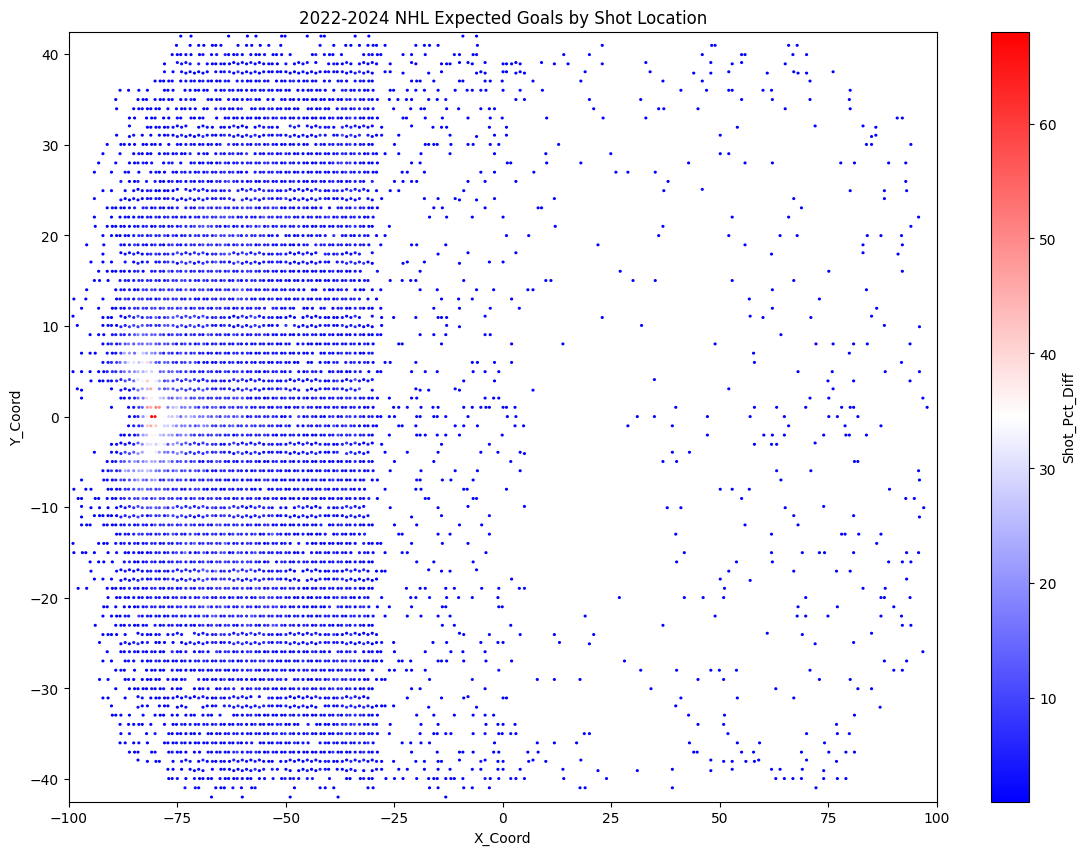

In [132]:
#tgt_player = 'Sidney.Crosby'
#
#plot_data = (
#    PBP_xG.filter((pl.col('x_fixed') > 26) & (pl.col('model_type') == 'EV'))
#    .with_columns(pl.when(pl.col("event_player_1_name") == tgt_player).then(pl.lit(tgt_player.replace(".", " "))).otherwise(pl.lit("NHL Average")).alias('Grouping'))
#    .with_columns([
#        pl.when(pl.col('event_type') == 'GOAL').then(pl.lit(1)).otherwise(pl.lit(0)).alias('Goals'),
#        pl.when(pl.col('event_type').is_in(['SHOT', "MISSED_SHOT"])).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Shots')
#    ])
#    .groupby("x_fixed", "y_fixed")
#    .agg([
#        (pl.col('xG').sum()).alias("NHL_xG_Pct"),
#        (((pl.col('Goals') == 1).sum()) ).alias("Ply_Shot_Pct")
#    ])
#    .with_columns([
#        ((pl.col("NHL_xG_Pct")) - (pl.col("Ply_Shot_Pct"))).alias("Shot_Pct_Diff")
#    ])
#    .select(["x_fixed", "y_fixed", "Shot_Pct_Diff"])
#    .to_pandas()
#)

plot_data = sdv.nhl.load_nhl_pbp(seasons=range(2023,2024)).select(nhl_pbp_cols).extend(sdv.nhl.load_nhl_pbp(seasons=range(2024,2025)).select(nhl_pbp_cols))

plot_data = (
    plot_data
    .filter((pl.col('event_type').is_in(fenwick_events)))
    .filter(~((pl.col('x_fixed').is_null()) & (pl.col('y_fixed').is_null())))
    .filter((pl.col('event_team_type') == 'away') & (pl.col('period') == 2))
    .with_columns((pl.lit(1)).alias('is_shot'))
    .groupby("x_fixed", "y_fixed", 'period')
    .agg(pl.col('is_shot').sum().alias('shots'))
    .select('x_fixed', 'y_fixed', 'shots', 'period')
    .to_pandas()
)

print(plot_data.period.unique())

#plot_data = (
#    EV_PBP
#    .select('x_fixed', 'y_fixed', 'is_goal')
#    .groupby("x_fixed", "y_fixed")
#    .agg(pl.col('is_goal').count().alias('shots'))
#    .to_pandas()
#)


plot_data.dropna(inplace = True)
plot_data.head()

rink = NHLRink(rotation=270, net={"visible": False})

## Define the axis limits
x_min, x_max = -100, 100
y_min, y_max = -42.5, 42.5

#shrunk_cmap = shiftedColorMap(matplotlib.cm.RdYlGn, start=plot_data['Shot_Pct_Diff'].min(), midpoint=0, stop=plot_data['Shot_Pct_Diff'].max(), name = 'NHL Total2')


# Create a custom colormap
colors = [(1, 0, 0), (1, 1, 1), (0, 1, 0)]  # Red to white to green
n_bins = 256
cmap_name = "custom"
#cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Modify the colormap to make 0 white
#cmap(np.linspace(0, 1, n_bins))
#cmap.set_bad('white')



## Create a heatmap
plt.figure(figsize=(14, 10))

hb = plt.hexbin(plot_data['x_fixed'], plot_data['y_fixed'], C=plot_data['shots'], gridsize=500, cmap="bwr", extent=(plot_data['x_fixed'].min(), plot_data['x_fixed'].max(), plot_data['y_fixed'].min(), plot_data['y_fixed'].max()))
cbar = plt.colorbar(hb)
cbar.set_label('Shot_Pct_Diff')

# Set the axis limits
plt.xlim(x_min, x_max)
print("X Min and Max: ", x_min, x_max)
plt.ylim(y_min, y_max)
print("Y Min and Max: ", y_min, y_max)

# Add labels and title
plt.xlabel('X_Coord')
plt.ylabel('Y_Coord')
plt.title('2022-2024 NHL Expected Goals by Shot Location')

# Show the plot
plt.show()

In [741]:
del shrunk_cmap

The following kwargs were not used by contour: 'statistic'


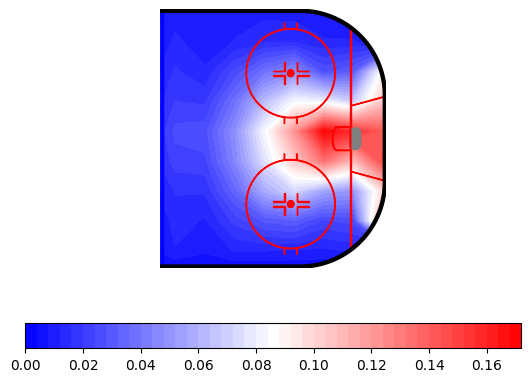

In [823]:
from hockey_rink import NHLRink

# Set Up Data
plot_data = (
    PBP_xG
    .filter(
        (pl.col('model_type') == 'EV')
    )
).to_pandas()

fig = plt.plot(figsize=(28,16))
rink = NHLRink(rotation=0)
rink.draw(display_range="ozone")

contour_img = rink.contourf(plot_data.x_abs, plot_data.y_abs, values=plot_data.xG, cmap="bwr", 
                            plot_range="ozone", binsize=10, levels=50, statistic="mean")
plt.colorbar(contour_img, orientation="horizontal")

In [809]:
PBP_xG.filter(
        (pl.col('model_type') == 'EV') &
        (pl.col('event_team_abbr') == 'PIT') &
        (pl.col('x_abs') > 89) &
        (pl.col('is_goal') == 1)
    ).head()

event_type,event,description,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,strength_state,event_idx,extra_attacker,home_skaters,away_skaters,game_id,period_type,ordinal_num,period_time,period_time_remaining,date_time,home_final,away_final,season,season_type,game_date,game_start,game_end,game_length,game_state,detailed_state,venue_name,venue_link,home_name,home_abbreviation,home_division_name,home_conference_name,home_id,away_name,away_abbreviation,away_division_name,away_conference_name,away_id,event_id,event_team,event_team_type,num_on,players_on,players_off,away_on_1,away_on_2,away_on_3,away_on_4,away_on_5,away_goalie,ids_on,ids_off,secondary_type,home_on_1,home_on_2,home_on_3,home_on_4,home_on_5,home_goalie,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,strength,x,y,x_fixed,y_fixed,event_player_1_id,event_player_1_link,event_player_2_id,event_player_2_link,event_team_id,event_team_link,event_team_abbr,num_off,penalty_severity,penalty_minutes,away_on_6,shot_distance,shot_angle,event_goalie_name,event_goalie_id,event_goalie_link,event_goalie_type,event_player_3_name,event_player_3_type,game_winning_goal,empty_net,event_player_3_id,event_player_3_link,event_player_4_type,event_player_4_id,event_player_4_name,event_player_4_link,home_on_6,venue_id,model_type,xG,is_goal,event_distance,shot_angle_right,x_abs,y_abs,is_set_play,is_rebound,reb_angle_change,reb_angle_change_speed,off_wing,hand_R,hand_L,pos_F,pos_D,pos_G,prior_shot_same,is_rush_play,seconds_since_last,puck_speed_since_last
str,str,str,i32,i32,i32,i32,i32,i32,i32,str,str,bool,i32,i32,i32,str,str,str,str,str,i32,i32,i32,str,str,str,str,i32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,i32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,i32,i32,i32,i32,str,i32,str,i32,str,str,i32,str,i32,str,f64,f64,str,i32,str,str,str,str,bool,bool,i32,str,str,i32,str,str,str,i32,str,f32,i32,f64,f64,i32,i32,i32,i32,f64,f64,i32,f64,f64,f64,f64,f64,i32,i32,i32,f64
"""GOAL""","""Goal""","""Bryan Rust (3)…",2,120,1080,1320,2280,1,3,"""5v5""","""0313""",false,5,5,2022020094,"""REGULAR""","""2nd""","""02:00""","""18:00""","""2022-10-25T01:…",6,3,2023,"""R""","""2022-10-24""","""2022-10-24 20:…","""2022-10-24 22:…",14,"""Final""","""Final""","""Rogers Place""","""/api/v1/venues…","""Edmonton Oiler…","""EDM""","""Pacific""","""Western""","""22""","""Pittsburgh Pen…","""PIT""","""Metropolitan""","""Eastern""","""5""",2.0220e13,"""Pittsburgh Pen…","""away""",null,null,null,"""Jan.Rutta""","""Bryan.Rust""","""Evgeni.Malkin""","""Jason.Zucker""","""Pierre.Olivier…","""Tristan.Jarry""",null,null,"""Backhand""","""Warren.Foegele…","""Ryan.Murray""","""Ryan.McLeod""","""Evan.Bouchard""","""Jesse.Puljujar…","""Jack.Campbell""","""Bryan.Rust""","""Scorer""","""Evgeni.Malkin""","""Assist""","""EV""","""Even""",91,10,-91,-10,8475810,"""/api/v1/people…",8471215,"""/api/v1/people…",5,"""/api/v1/teams/…","""PIT""",null,null,null,null,10.2,101.3,"""Jack.Campbell""",8475789,"""/api/v1/people…","""Goalie""","""Jason.Zucker""","""Assist""",false,false,8475722,"""/api/v1/people…","""Goalie""",8475789,"""Jack Campbell""","""/api/v1/people…",null,5100,"""EV""",0.115732,1,10.198039,101.3,91,10,0,0,0.0,0.0,1,1.0,0.0,1.0,0.0,0.0,0,0,0,37.20215
"""GOAL""","""Goal""","""Bryan Rust (2)…",3,18,1182,2418,1182,1,1,"""5v5""","""0521""",false,5,5,2023020025,"""REGULAR""","""3rd""","""00:18""","""19:42""","""2023-10-15T01:…",5,2,2024,"""R""","""2023-10-14""","""2023-10-14 19:…","""2023-10-14 21:…",23,"""Final""","""Final""","""PPG Paints Are…","""/api/v1/venues…","""Pittsburgh Pen…","""PIT""","""Metropolitan""","""Eastern""","""5""","""Calgary Flames…","""CGY""","""Pacific""","""Western""","""20""",2.0230e13,"""Pittsburgh Pen…","""home""",null,null,null,"""Jonathan.Huber…","""Rasmus.Anderss…","""Noah.Hanifin""","""Andrew.Mangiap…","""Elias.Lindholm…","""

In [ ]:
# Library
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math
from PIL import Image

# Needed for custom colour mapping!
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors

# Target Player
full_name = 'Sidney Crosby'

# Load Data
filter_var = ''
plot_keep_cols = ['event_player_1_name', 'event_player_1_id', 'x_abs', 'y_abs', 'is_goal', 'secondary_tpye', 'is_rebound', '']

plot_data = (
    PBP_xG
    .filter()
)


# Color Map
c = mcolors.ColorConverter().to_rgb()
positive_cm = ListedColormap([c("#e1e5e5"),c("#d63b36")])
negative_cm = ListedColormap([c("#e1e5e5"),c("#d63b36")])

# Set Plot Variables
gridsize=30;mincnt=0

# Player Data Creation
